In [1]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Load Data

In [2]:
nexrad = pd.read_csv(config.dataFol+'clean_nexrad/clean_nexrad.csv')
yamnet = pd.read_csv(config.dataFol+'clean_yamnet/clean_yamnet.csv',
                     names = ['sonyc_sensor_id', 'timestamp',
                              'count_of_positive_predictions', 'pct_positive_predictions'])
sensors = pd.read_json(config.dataFol+"sonyc_test.collection.json")
df = pd.read_csv(config.dataFol+'all_cleaned_wsp_sonyc_birds.csv')

In [4]:
df

,timestamp,sonyc_sensor_id,sonyc_sensor_name,dBAS_lin_mean,count_of_positive_predictions,pct_positive_predictions,avg_mtr_#/km/h,avg_mt_#/km,avg_height_m,temp_celcius,dewp_celcius,rh_percentage,wind_dir,wind_speed_mph,sea_level_pressure_mb,precipitation_mm,visibility_miles,gust_mph,peak_wind_gust_mph
0,2017-03-02 07:00,b827eb815321,19 Washington Square North,59.166330,0.0,0.04918,19.631140,26118.316155,284.230912,16.11,6.11,51.48,280.0,28.75,996.8,0.0,10.0,43.70,44.85
1,2017-03-02 07:00,b827eb0fedda,Juan Carlos,53.477207,0.0,0.03333,19.631140,26118.316155,284.230912,16.11,6.11,51.48,280.0,28.75,996.8,0.0,10.0,43.70,44.85
2,2017-03-02 07:00,b827eb1685c7,Shimkin Reading Room,61.856247,0.0,0.00000,19.631140,26118.316155,284.230912,16.11,6.11,51.48,280.0,28.75,996.8,0.0,10.0,43.70,44.85
3,2017-03-02 07:01,b827eb815321,19 Washington Square North,57.641624,0.0,0.04918,19.631140,26118.316155,284.230912,16.11,6.11,51.48,280.0,28.75,996.8,0.0,10.0,43.70,44.85
4,2017-03-02 07:01,b827eb0fedda,Juan Carlos,60.136166,0.0,0.03333,19.631140,26118.316155,284.230912,16.11,6.11,51.48,280.0,28.75,996.8,0.0,10.0,43.70,44.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756875,2020-05-12 00:57,b827eb0fedda,Juan Carlos,54.906480,0.0,0.00000,192.111044,206086.239903,159.548564,11.11,3.89,61.06,290.0,16.10,1011.7,0.0,10.0,24.15,29.90
756876,2020-05-12 00:58,b827eb8e2420,4 Washington Square North,55.073470,0.0,0.00000,100.247265,378124.755593,169.243472,11.11,3.89,61.06,290.0,16.10,1011.7,0.0,10.0,24.15,29.90
756877,2020-05-12 00:58,b827eb0fedda,Juan Carlos,54.387170,0.0,0.00000,100.247265,378124.755593,169.243472,11.11,3.89,61.06,290.0,16.10,1011.7,0.0,10.0,24.15,29.90
756878,2020-05-12 00:59,b827eb8e2420,4 Washington Square North,52.649155,0.0,0.00000,100.247265,378124.755593,169.243472,11.11,3.89,61.06,290.0,16.10,1011.7,0.0,10.0,24.15,29.90


#### Processing Nexrad Data
* convert timestamps from UTC to US/Eastern

In [3]:
nexrad['timestamp'] = pd.to_datetime(nexrad['timestamp']) \
    .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
nexrad['year'] = pd.DatetimeIndex(nexrad['timestamp']).year
nexrad['month'] = pd.DatetimeIndex(nexrad['timestamp']).month
nexrad['day'] = pd.DatetimeIndex(nexrad['timestamp']).day
nexrad['hour'] = pd.DatetimeIndex(nexrad['timestamp']).hour

In [4]:
nexradByHour = nexrad.groupby(['radar_name', 'year', 'month', 'day', 'hour']) \
    .mean().reset_index()
nexradByHour = nexradByHour.loc[(nexradByHour.month >=3) & (nexradByHour.month <=5)]
nexradByHour['year'] = nexradByHour.year.astype(str)
nexradByHour['month'] = nexradByHour.month.apply(lambda x: '{0:0>2}'.format(x))
nexradByHour['day'] = nexradByHour.day.apply(lambda x: '{0:0>2}'.format(x))
nexradByHour['hour'] = nexradByHour.hour.apply(lambda x: '{0:0>2}'.format(x))
nexradByHour['datetime'] = nexradByHour['year']+'-'+nexradByHour['month']+ \
    '-'+nexradByHour['day']+' '+nexradByHour['hour']+':00'
nexradByHour['datetime'] = pd.to_datetime(nexradByHour.datetime)
nexradByHour.head()

,radar_name,year,month,day,hour,mtr_#/km/h,mt_#/km,height_m,datetime
867,KDIX,2016,03,01,00,12.517557,77695.750168,256.743073,2016-03-01 00:00:00
868,KDIX,2016,03,01,01,11.103028,77707.915408,238.050354,2016-03-01 01:00:00
869,KDIX,2016,03,01,02,11.848719,77718.963251,246.004669,2016-03-01 02:00:00
870,KDIX,2016,03,01,03,13.751105,77732.398785,222.346276,2016-03-01 03:00:00
871,KDIX,2016,03,01,04,12.526025,77745.251687,243.396172,2016-03-01 04:00:00


##### Standardized hourly metrics by radar by month by hour

In [5]:
nexradMonthly = nexradByHour.groupby(['radar_name','year','month','hour']) \
    .agg(['mean', 'std']).reset_index()
nexradMonthly['hour_est'] = nexradMonthly.hour.astype(float)
nexradMonthly.columns = ["_".join(x) for x in nexradMonthly.columns.ravel()]
nexradMonthly.rename(columns={'radar_name_':'radar', 'year_':'year', 
                             'month_':'month', 'hour_est_':'hour_est',
                             'hour_':'hour'}, inplace=True)
nexradMonthly.head()

,radar,year,month,hour,mtr_#/km/h_mean,mtr_#/km/h_std,mt_#/km_mean,mt_#/km_std,height_m_mean,height_m_std,hour_est
0,KDIX,2016,03,00,288.787221,527.371169,112617.881460,27066.731696,524.023983,265.202548,0.0
1,KDIX,2016,03,01,237.140774,379.351103,112878.600364,27195.689229,496.891653,232.024913,1.0
2,KDIX,2016,03,02,158.107033,254.677508,113533.727073,27634.602385,473.897411,230.684489,2.0
3,KDIX,2016,03,03,104.935887,150.492449,113193.596996,27344.821725,477.439129,281.809652,3.0
4,KDIX,2016,03,04,71.760967,99.128700,113277.058715,27356.432150,420.663645,226.369486,4.0


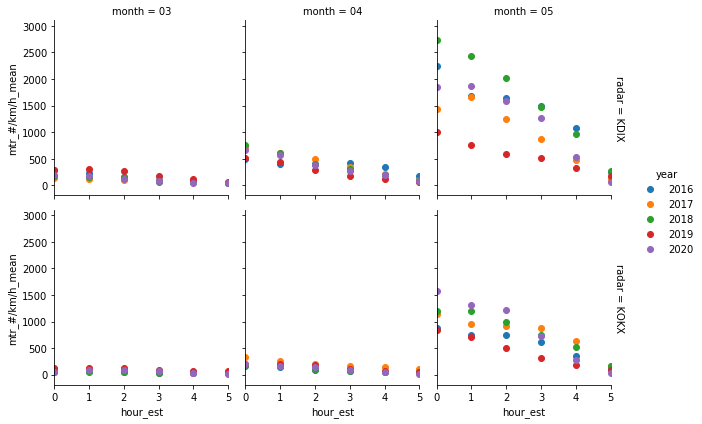

In [6]:
g = sns.FacetGrid(nexradMonthly, row='radar', 
                  col="month", hue='year', xlim=(0,5),
                  margin_titles=True)
g.map(plt.scatter, "hour_est", "mtr_#/km/h_mean")
g.add_legend()

In [7]:
nexradByHour = pd.merge(nexradByHour, nexradMonthly,
                        left_on = ['radar_name', 'year', 'month', 'hour'],
                        right_on = ['radar', 'year', 'month', 'hour'])
nexradByHour['mtr_z_score'] = (nexradByHour['mtr_#/km/h'] - nexradByHour['mtr_#/km/h_mean']) / nexradByHour['mtr_#/km/h_std']

#### Processing YAMNet Data
* find the sonyc sensor name for easy comprehension
* convert timestamps from UTC to US/Eastern

In [8]:
bird_sensors = ['sonycnode-b827eb815321.sonyc', # 19 Washington Square North - 15-61 Washington Square N, New York, NY 10011
                'sonycnode-b827eb8e2420.sonyc', # 4 Washington Square North 1-6 Washington Square North, New York, NY 10003
                'sonycnode-b827eb86d458.sonyc', # Silver Lab - 60 5th Ave
                'sonycnode-b827eb905497.sonyc', # Kimmel Center	60 Washington Square S, New York, NY 10012
                'sonycnode-b827eb0fedda.sonyc', # Juan Carlos	King Juan Carlos I of Spain Center, 53 Washington Square S, New York, NY 10012
                'sonycnode-b827eb1685c7.sonyc'] # Shimkin Reading Room	35-51 West 4th Street, New York, NY 10012

sensors = sensors.loc[sensors.fqdn.isin(bird_sensors)][['fqdn', 'title']]
sensors['sonyc_sensor_id'] = sensors.fqdn.str[10:-6]
yamnet = sensors.merge(yamnet, on='sonyc_sensor_id')

In [9]:
yamnet['timestamp'] = pd.to_datetime(yamnet['timestamp']) \
    .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
yamnet['year'] = pd.DatetimeIndex(yamnet['timestamp']).year
yamnet['month'] = pd.DatetimeIndex(yamnet['timestamp']).month
yamnet['day'] = pd.DatetimeIndex(yamnet['timestamp']).day
yamnet['hour'] = pd.DatetimeIndex(yamnet['timestamp']).hour
yamnet.rename(columns={'title':'sensor'}, inplace=True)

In [10]:
yamnetByHour = yamnet[['sensor', 'pct_positive_predictions',
                       'year', 'month', 'day', 'hour']].drop_duplicates()
yamnetByHour = yamnetByHour[(yamnetByHour.month >=3) & (yamnetByHour.month <=5)]
yamnetByHour['year'] = yamnetByHour.year.astype(str)
yamnetByHour['month'] = yamnetByHour.month.apply(lambda x: '{0:0>2}'.format(x))
yamnetByHour['day'] = yamnetByHour.day.apply(lambda x: '{0:0>2}'.format(x))
yamnetByHour['hour'] = yamnetByHour.hour.apply(lambda x: '{0:0>2}'.format(x))
yamnetByHour['datetime'] = yamnetByHour['year']+'-'+yamnetByHour['month']+ \
    '-'+yamnetByHour['day']+' '+yamnetByHour['hour']+':00'
yamnetByHour['datetime'] = pd.to_datetime(yamnetByHour.datetime)
yamnetByHour.head()

,sensor,pct_positive_predictions,year,month,day,hour,datetime
0,Kimmel Center,0.00,2017,03,15,06,2017-03-15 06:00:00
43,Kimmel Center,0.00,2017,03,15,07,2017-03-15 07:00:00
103,Kimmel Center,0.00,2017,03,15,08,2017-03-15 08:00:00
162,Kimmel Center,0.05,2017,03,15,09,2017-03-15 09:00:00
222,Kimmel Center,0.00,2017,03,15,10,2017-03-15 10:00:00


##### Standardized hourly pct_positive_predictions by sensor by month by hour

In [11]:
yamnetMonthly = yamnetByHour.groupby(['sensor','year','month','hour']) \
    .agg(['mean', 'std']).reset_index()
yamnetMonthly['hour_est'] = yamnetMonthly.hour.astype(float)
yamnetMonthly.columns = ["_".join(x) for x in yamnetMonthly.columns.ravel()]
yamnetMonthly.rename(columns={'sensor_':'sensor', 'year_':'year', 
                             'month_':'month', 'hour_est_':'hour_est',
                             'hour_':'hour'}, inplace=True)
yamnetMonthly.head()

,sensor,year,month,hour,pct_positive_predictions_mean,pct_positive_predictions_std,hour_est
0,19 Washington Square North,2017,03,00,0.000000,0.000000,0.0
1,19 Washington Square North,2017,03,01,0.012630,0.032425,1.0
2,19 Washington Square North,2017,03,02,0.023180,0.031289,2.0
3,19 Washington Square North,2017,03,03,0.029075,0.038015,3.0
4,19 Washington Square North,2017,03,04,0.043139,0.044035,4.0


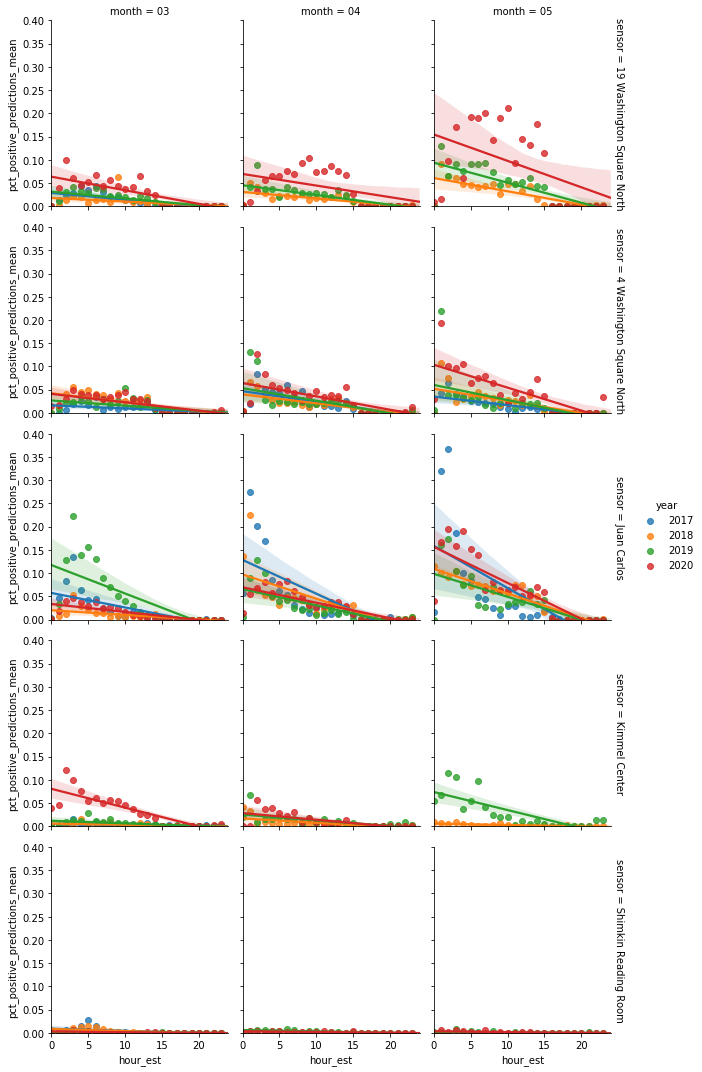

In [12]:
g = sns.FacetGrid(yamnetMonthly, row='sensor', 
                  col="month", hue='year', ylim=(0, 0.4), xlim=(0,24),
                  margin_titles=True)
g.map(sns.regplot, "hour_est", "pct_positive_predictions_mean")
g.add_legend()

In [13]:
yamnetByHour = pd.merge(yamnetByHour, yamnetMonthly, on = ['sensor', 'year', 'month', 'hour'])
yamnetByHour['preds_z_score'] = (yamnetByHour.pct_positive_predictions - yamnetByHour.pct_positive_predictions_mean) / yamnetByHour.pct_positive_predictions_std

### Merge the Hourly Nexrad + Yamnet

In [14]:
mergeByHour = pd.merge(nexradByHour[nexradByHour.radar_name=='KDIX'][['datetime', 'mtr_#/km/h','mtr_z_score']], 
                       yamnetByHour[['sensor', 'datetime', 'year', 'month', 'day', 'hour', 'hour_est',
                                     'pct_positive_predictions', 'preds_z_score']], 
                       on='datetime')
mergeByHour.head()

,datetime,mtr_#/km/h,mtr_z_score,sensor,year,month,day,hour,hour_est,pct_positive_predictions,preds_z_score
0,2017-03-01,4.087269,-0.419730,Shimkin Reading Room,2017,03,01,00,0.0,0.00000,NaN
1,2017-03-01,4.087269,-0.419730,19 Washington Square North,2017,03,01,00,0.0,0.00000,NaN
2,2017-03-01,4.087269,-0.419730,Juan Carlos,2017,03,01,00,0.0,0.08333,4.902903
3,2017-03-02,13.640011,-0.391276,Shimkin Reading Room,2017,03,02,00,0.0,0.00000,NaN
4,2017-03-02,13.640011,-0.391276,19 Washington Square North,2017,03,02,00,0.0,0.00000,NaN


In [27]:
nexradYamnetDict = dict(list(mergeByHour.groupby(['sensor'])))
for key in nexradYamnetDict.keys():
    print(key)
    nexradYamnetDict[key].set_index('datetime', inplace=True)
    nexradYamnetDict[key] = dict(list(nexradYamnetDict[key].groupby(['year', 'month'])))

19 Washington Square North
4 Washington Square North
Juan Carlos
Kimmel Center
Shimkin Reading Room


In [32]:
nexradYamnetDict['19 Washington Square North'].keys()

dict_keys([('2017', '03'), ('2018', '03'), ('2018', '04'), ('2018', '05'), ('2019', '03'), ('2019', '04'), ('2020', '03'), ('2020', '04'), ('2020', '05')])

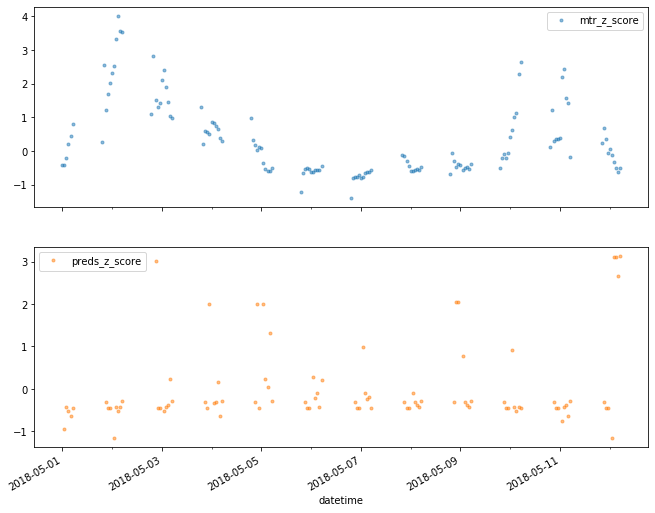

In [36]:
cols_plot = ['mtr_z_score','preds_z_score']
axes = nexradYamnetDict['19 Washington Square North'][('2018', '05')][cols_plot] \
    .plot(marker='.',alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

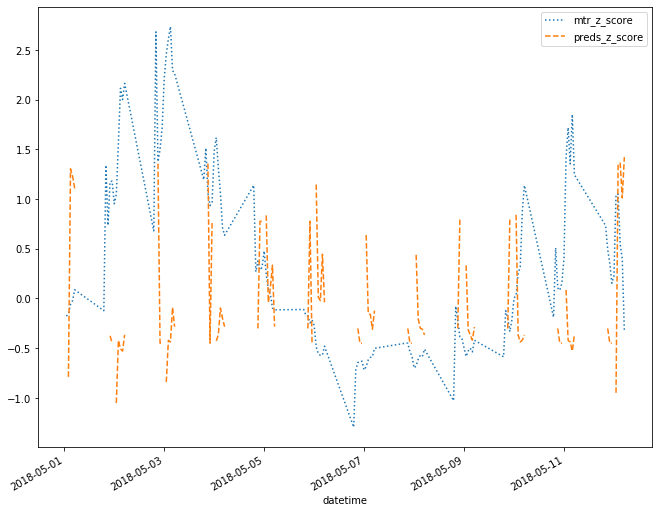

In [38]:
nexradYamnetDict['19 Washington Square North'][('2018', '05')][cols_plot]\
    .rolling(2, center=True).mean().plot(figsize=(11, 9),style=[':', '--', '-'])

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


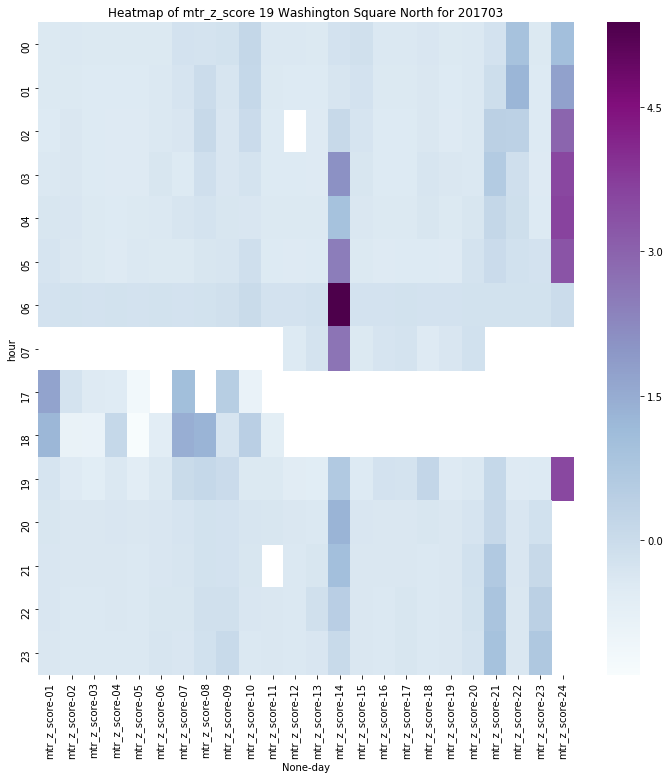

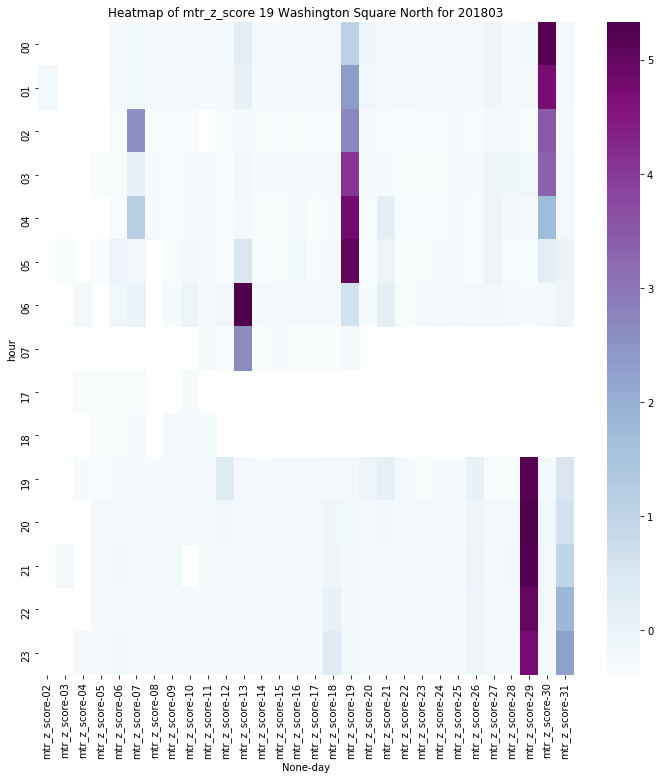

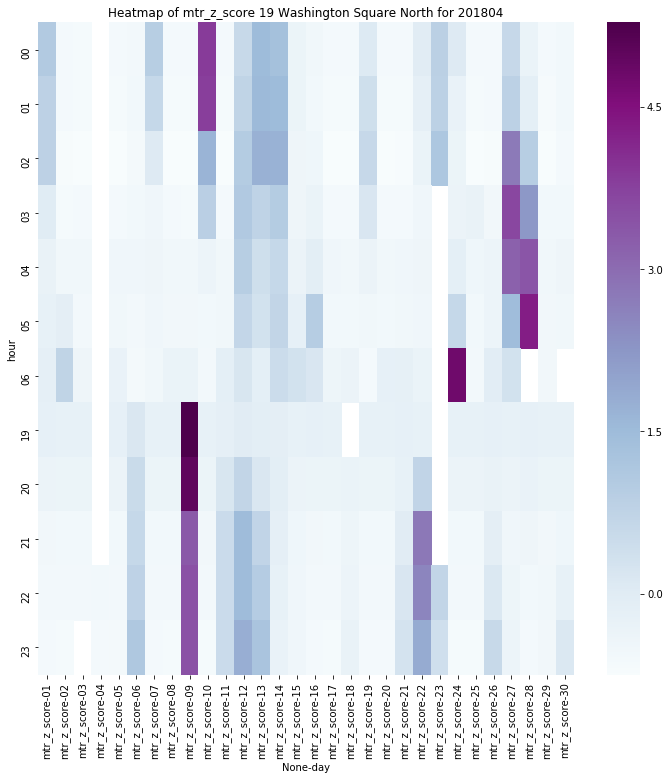

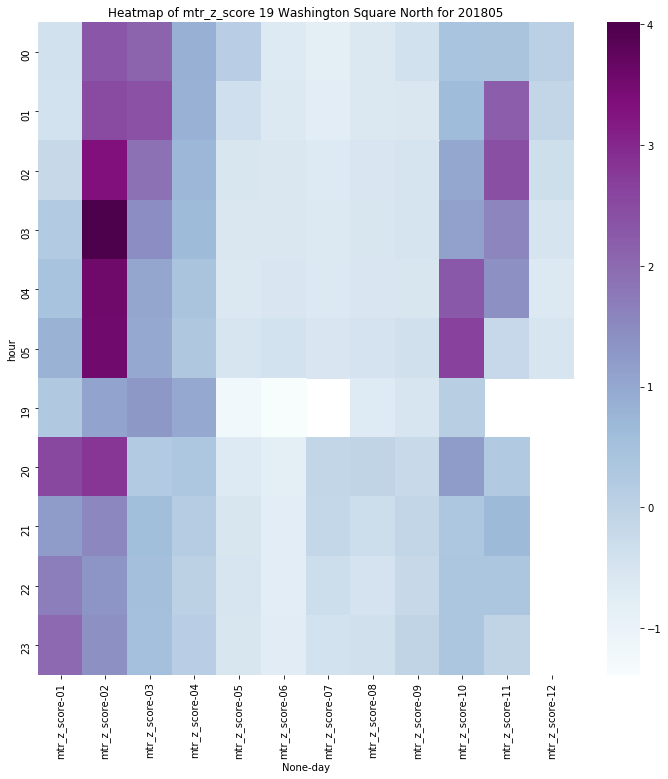

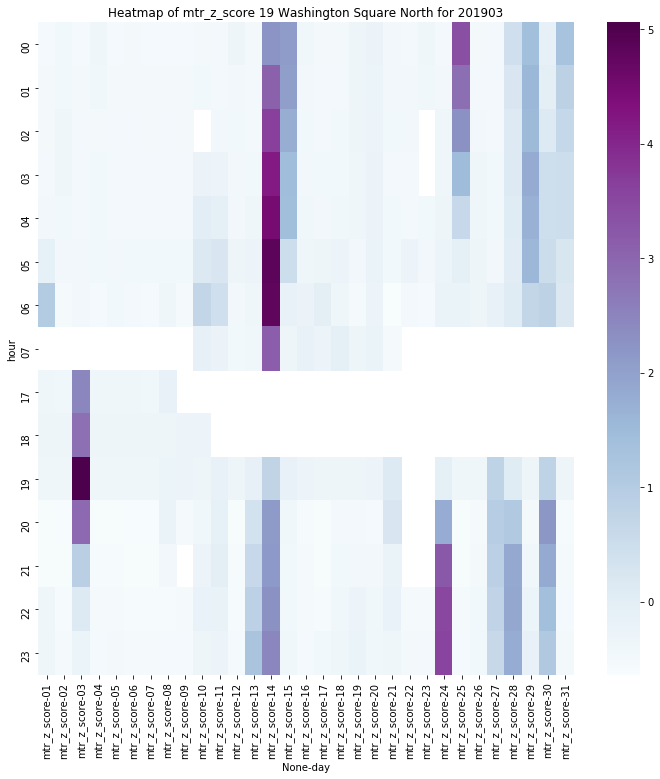

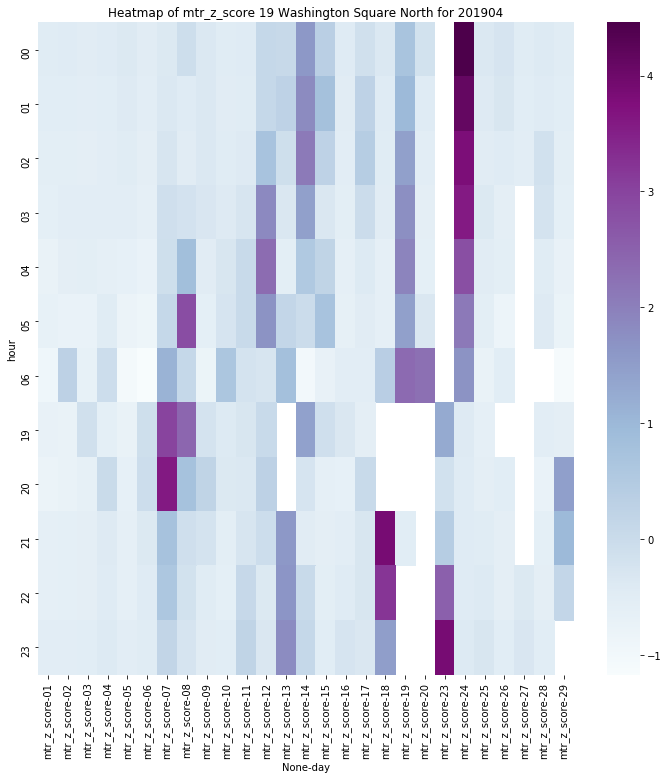

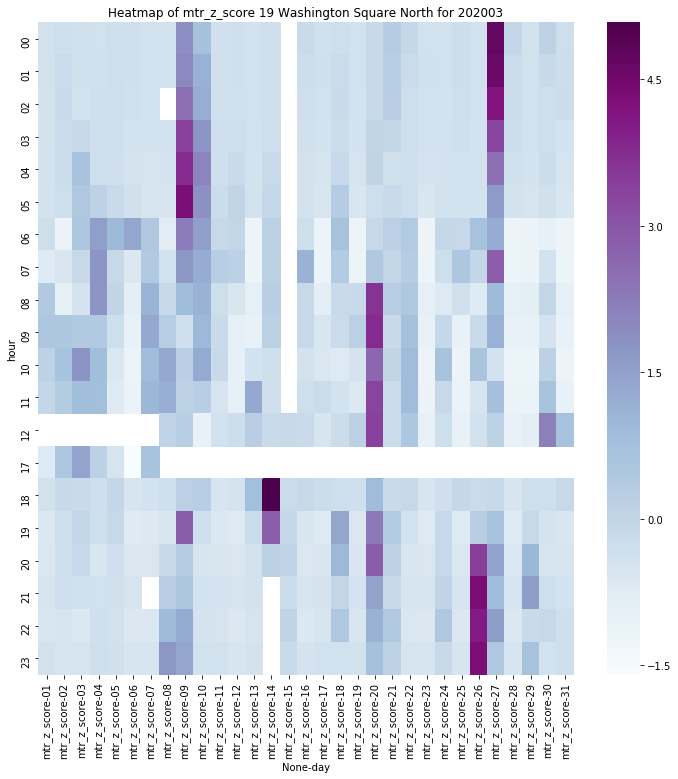

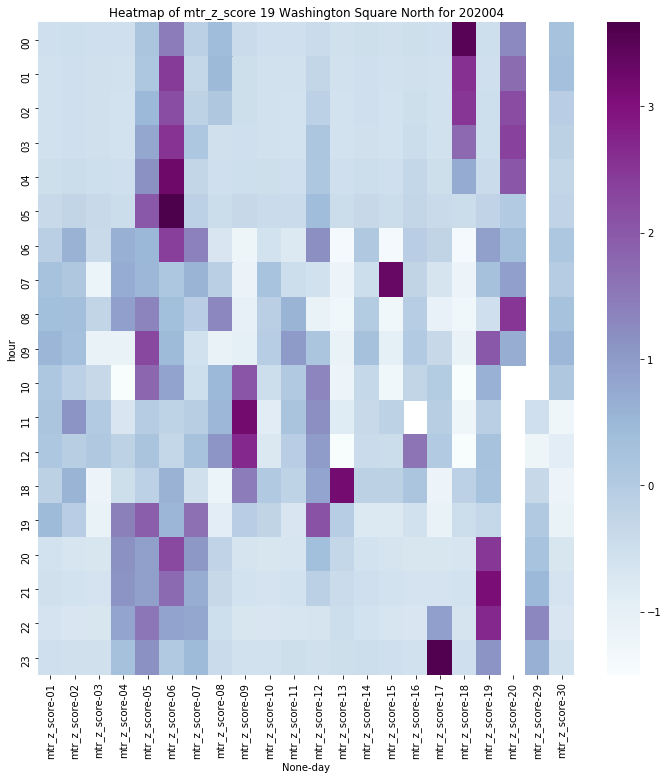

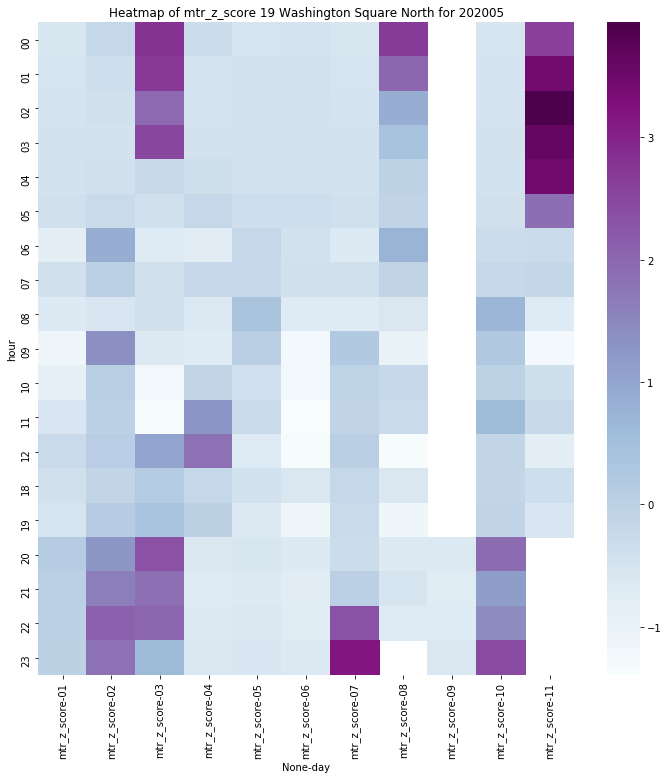

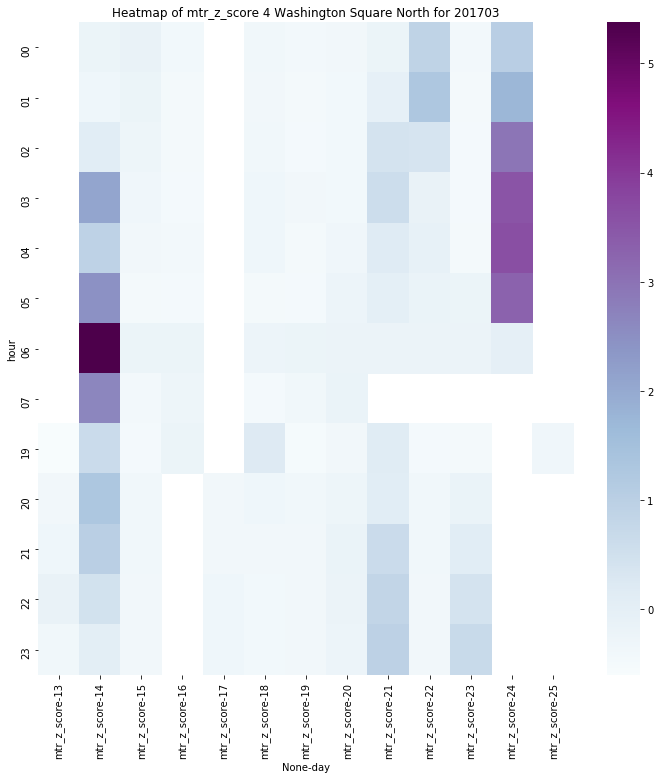

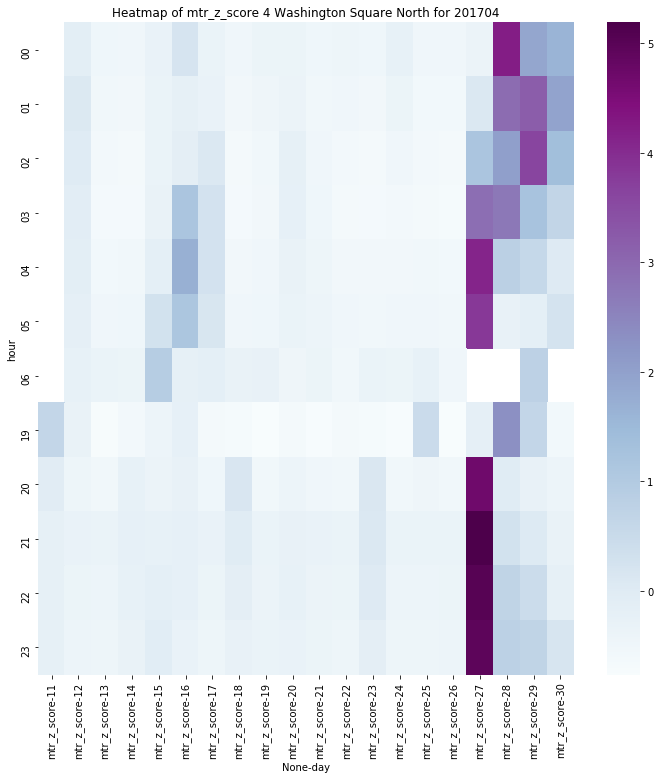

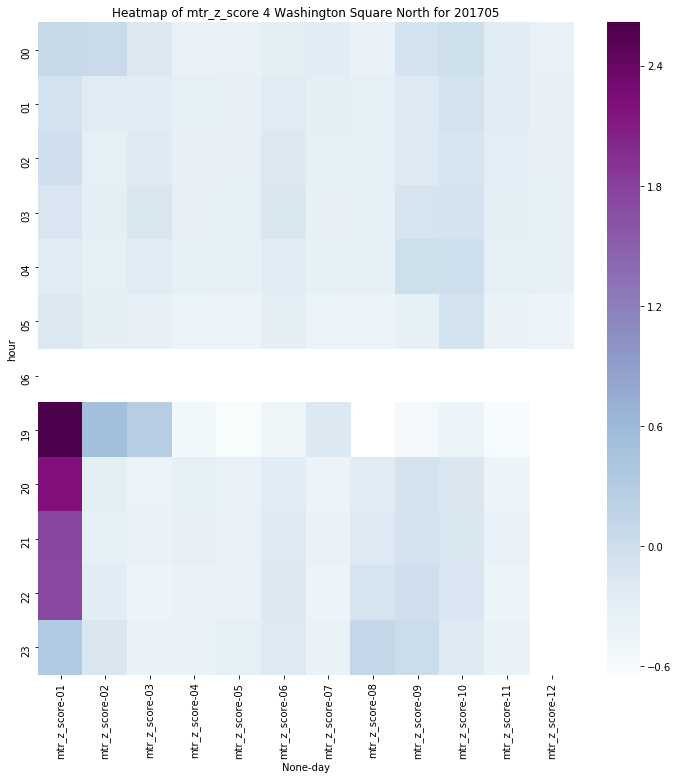

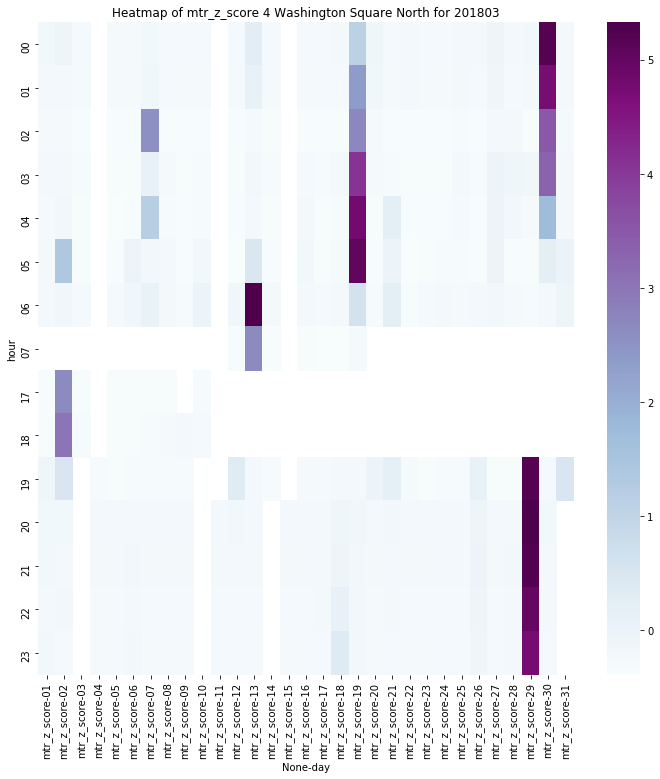

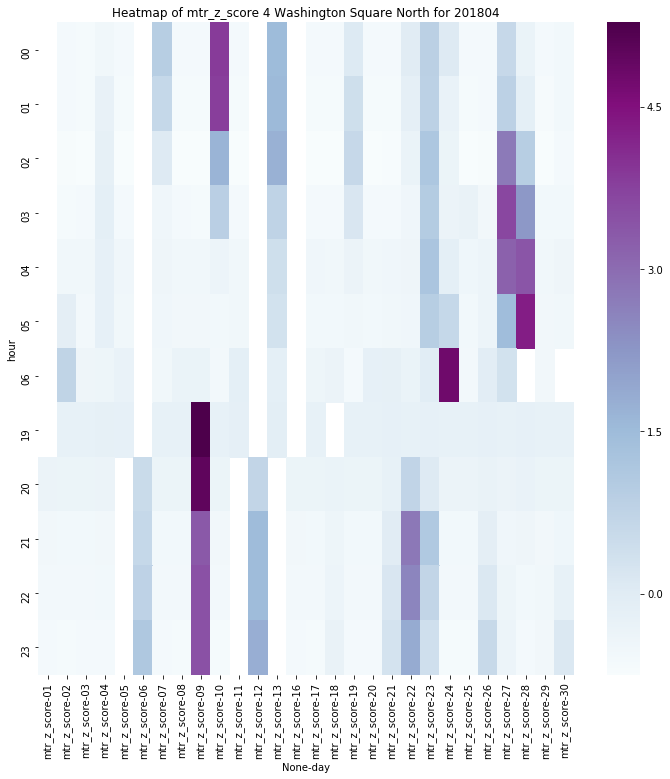

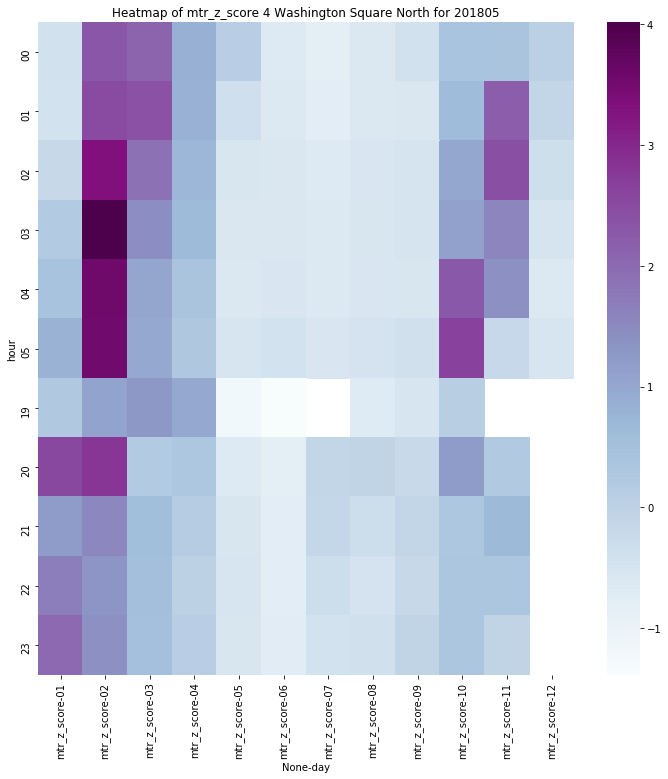

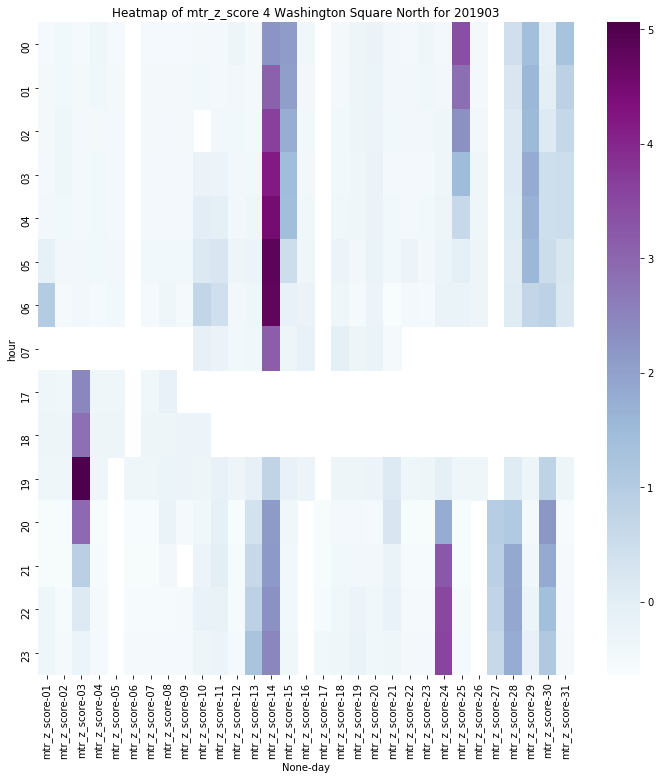

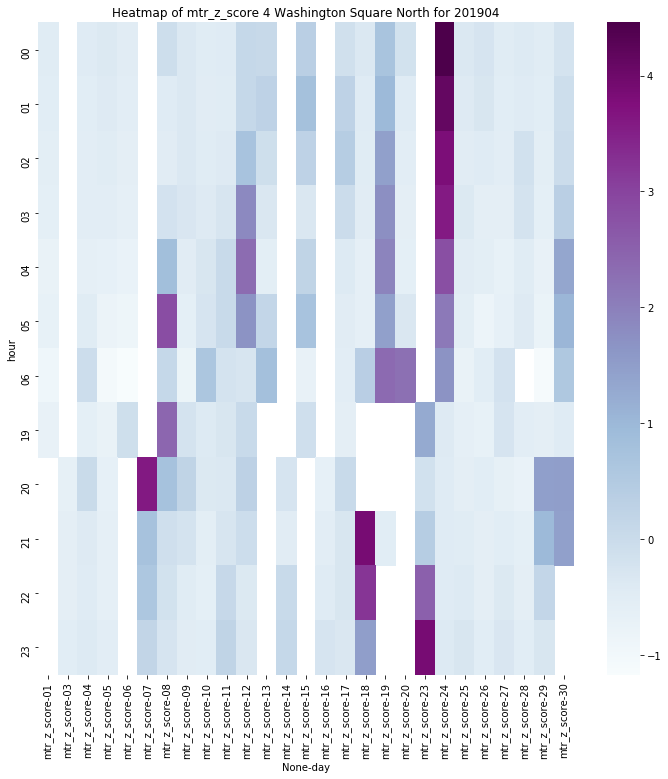

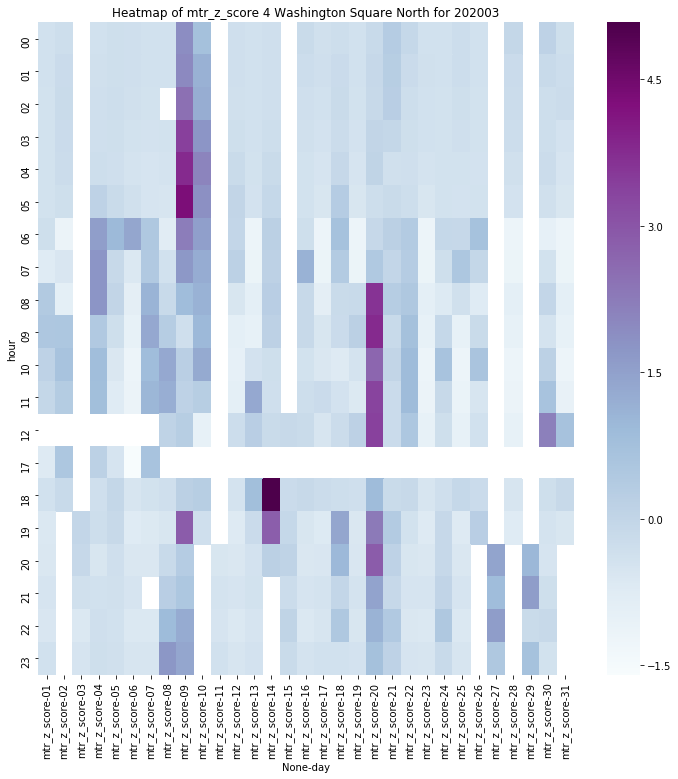

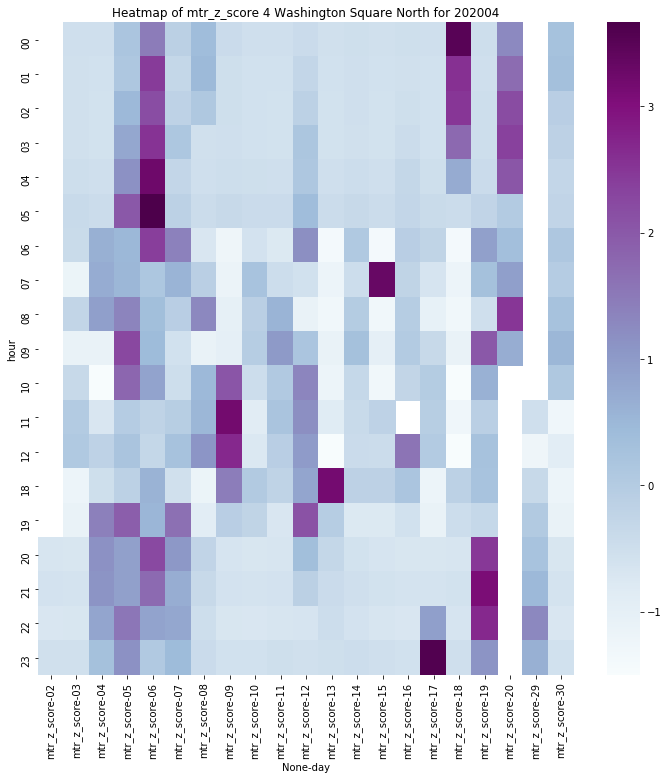

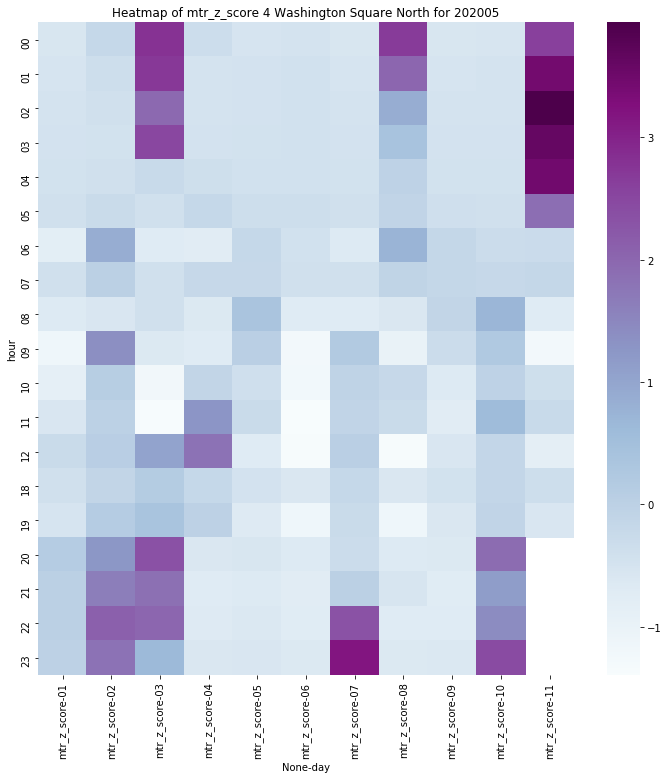

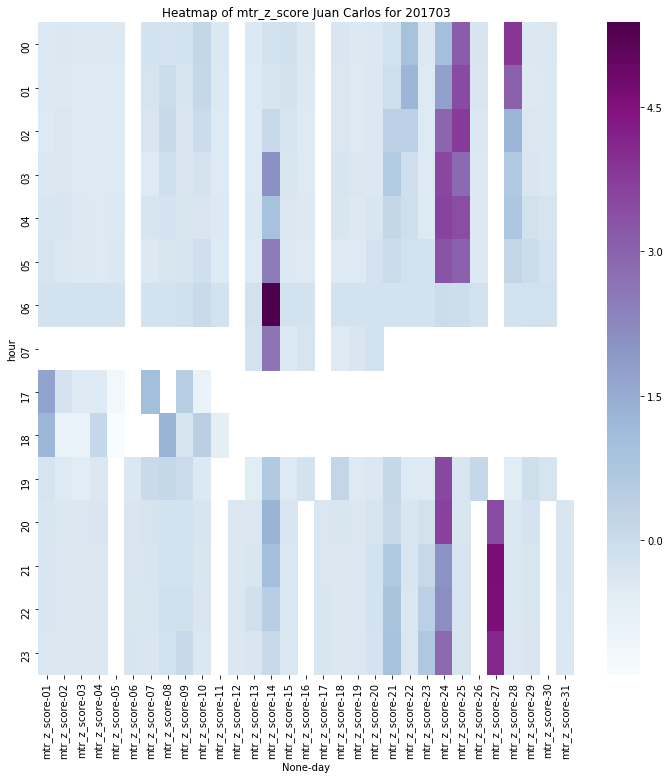

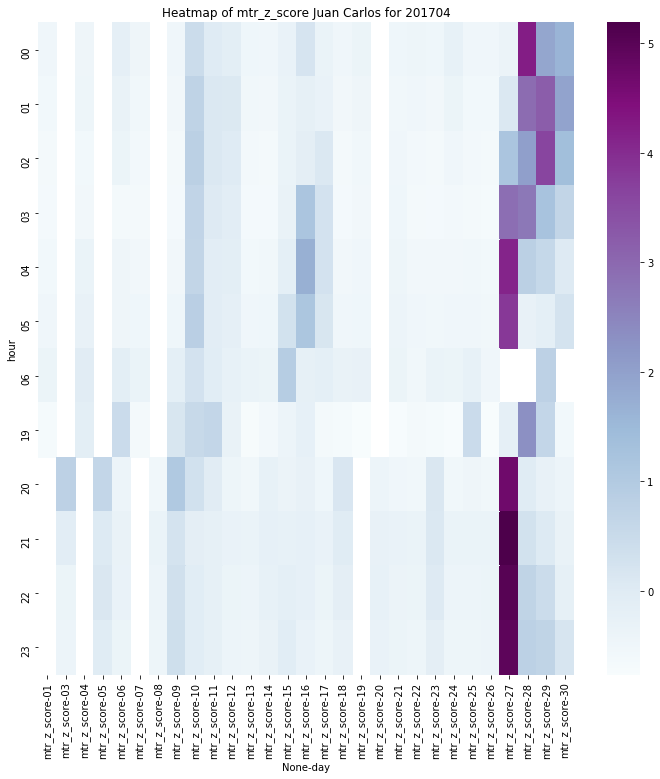

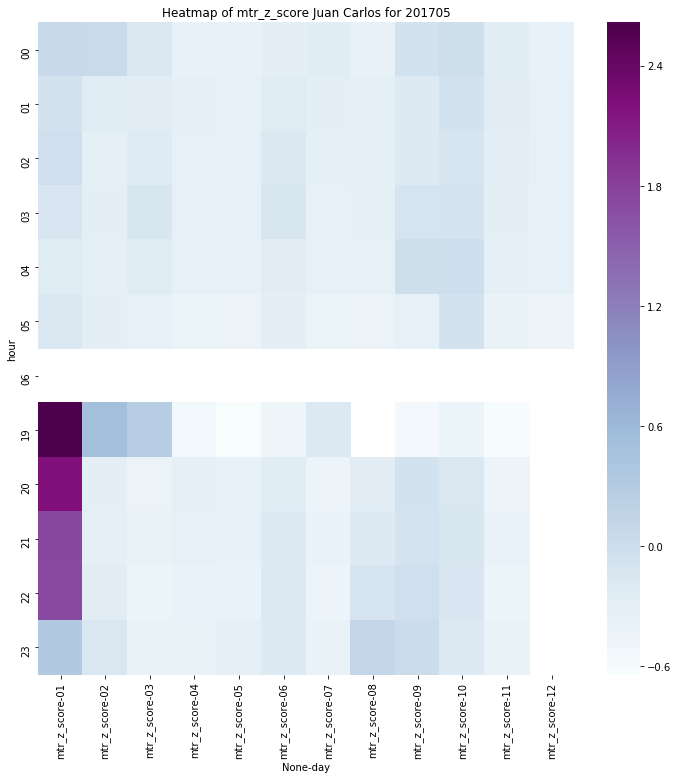

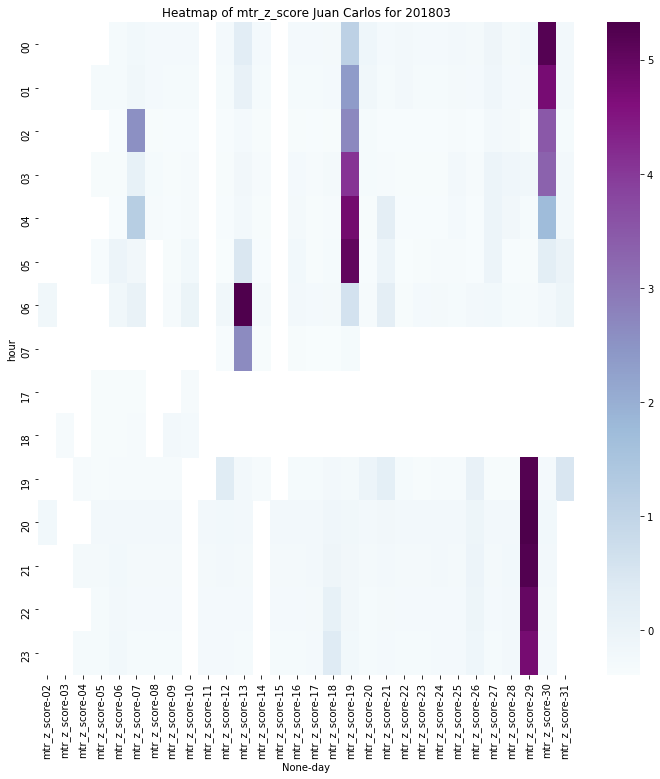

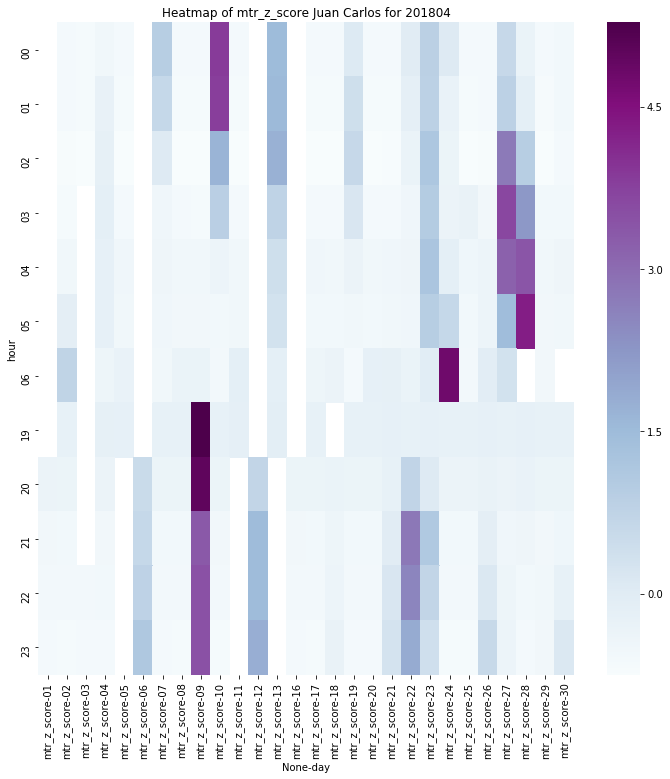

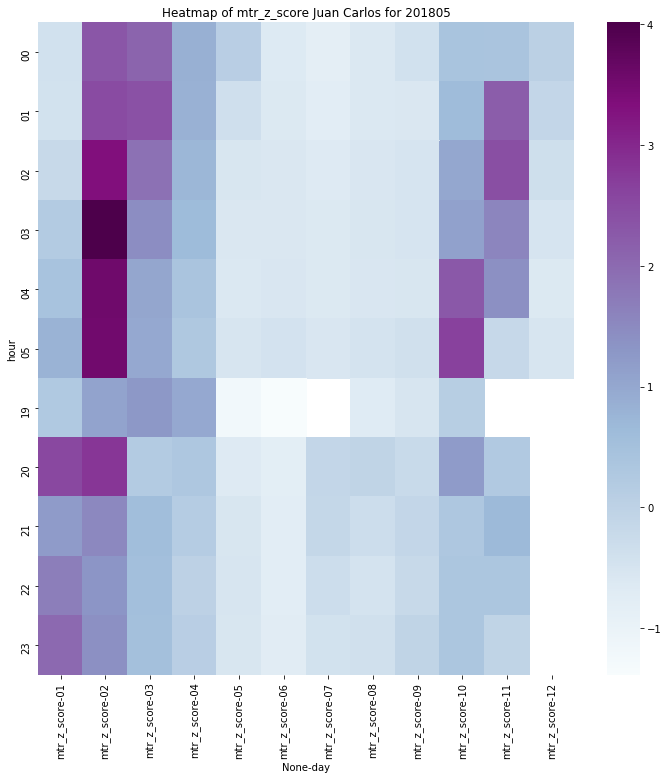

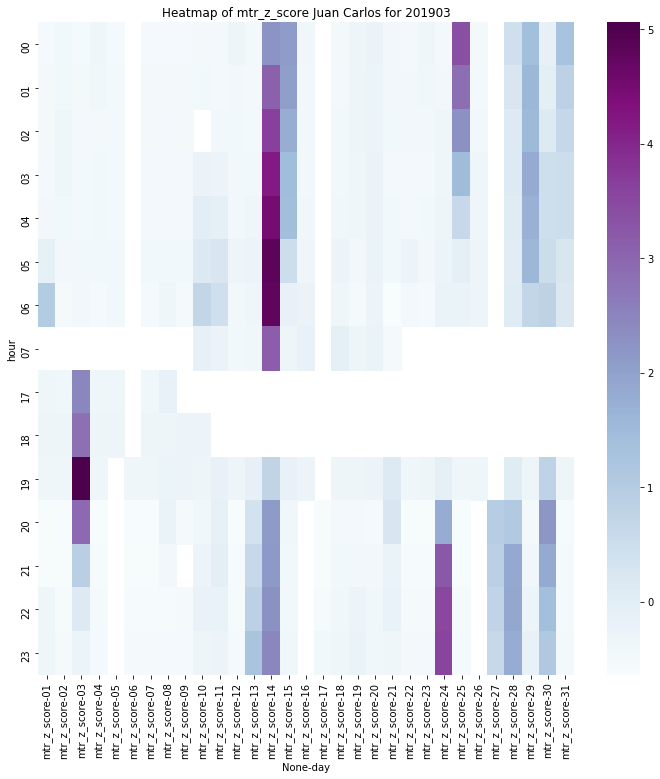

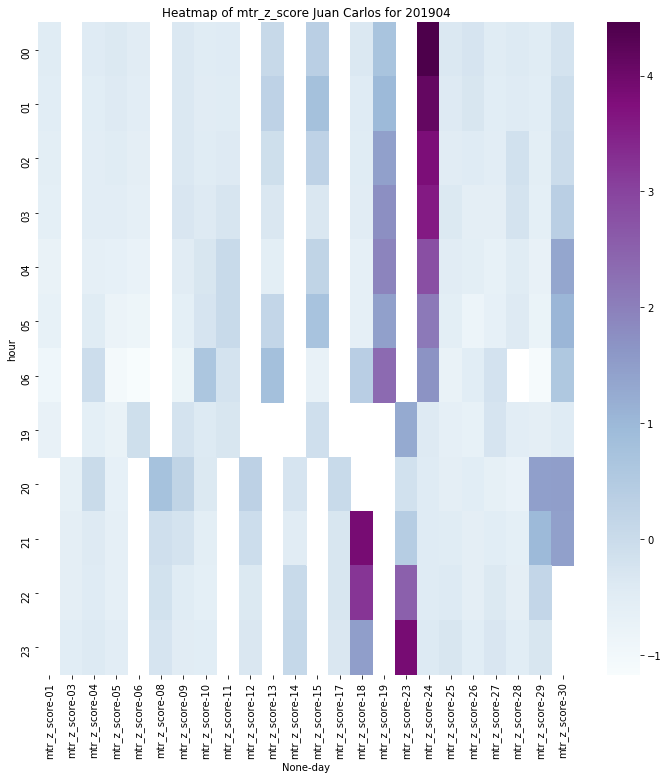

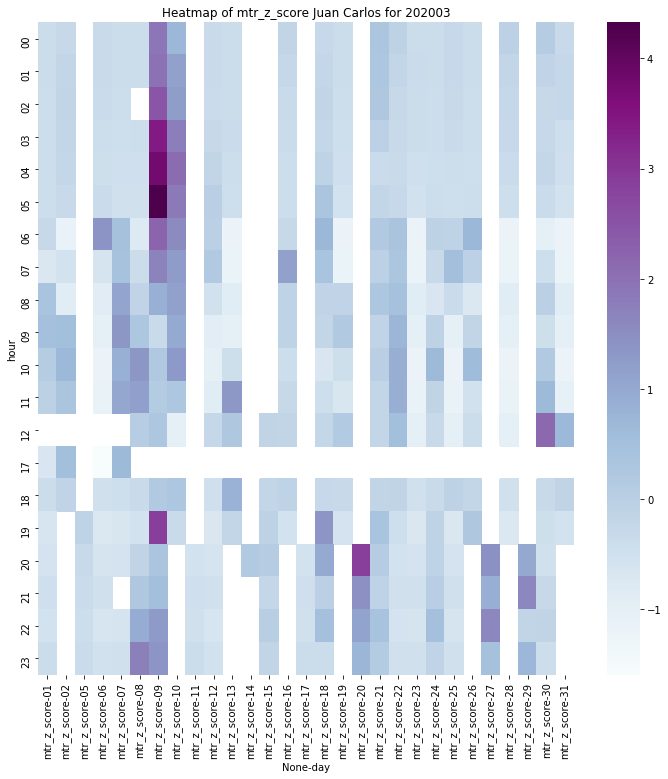

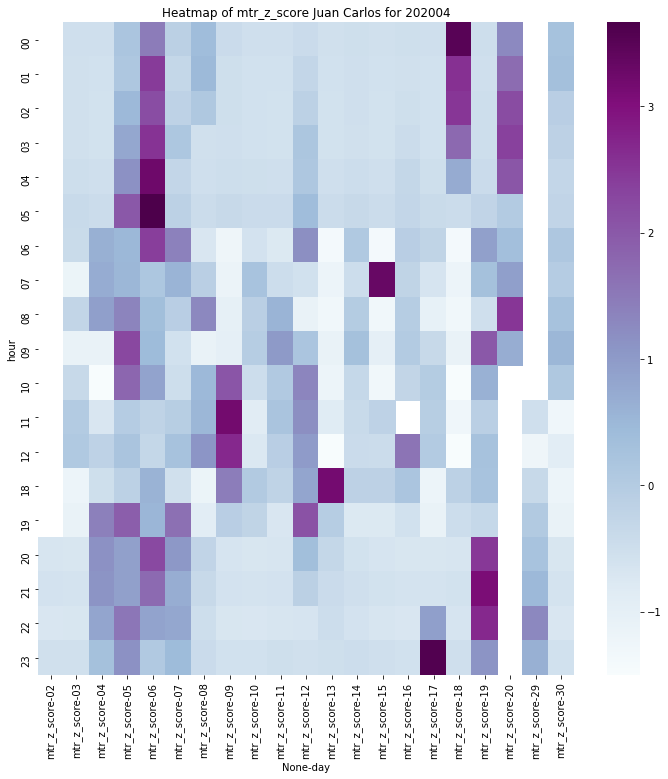

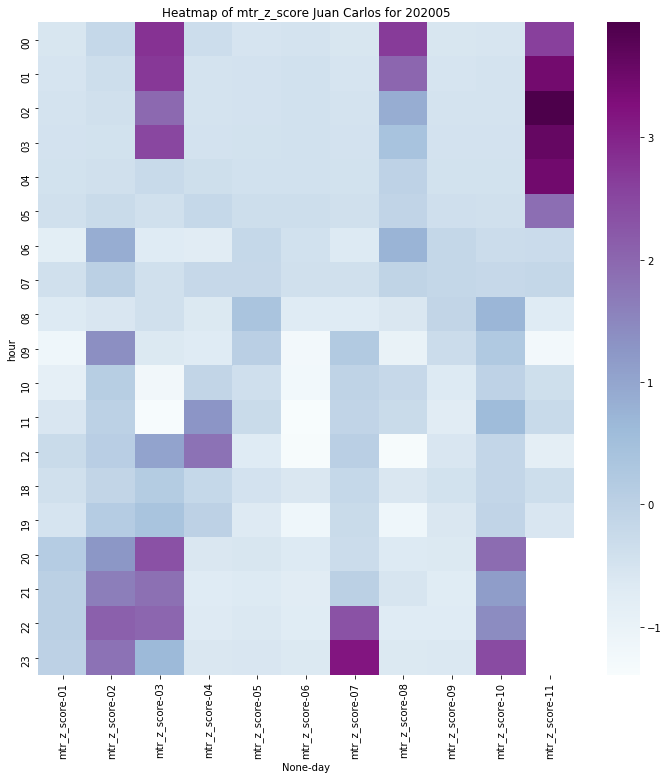

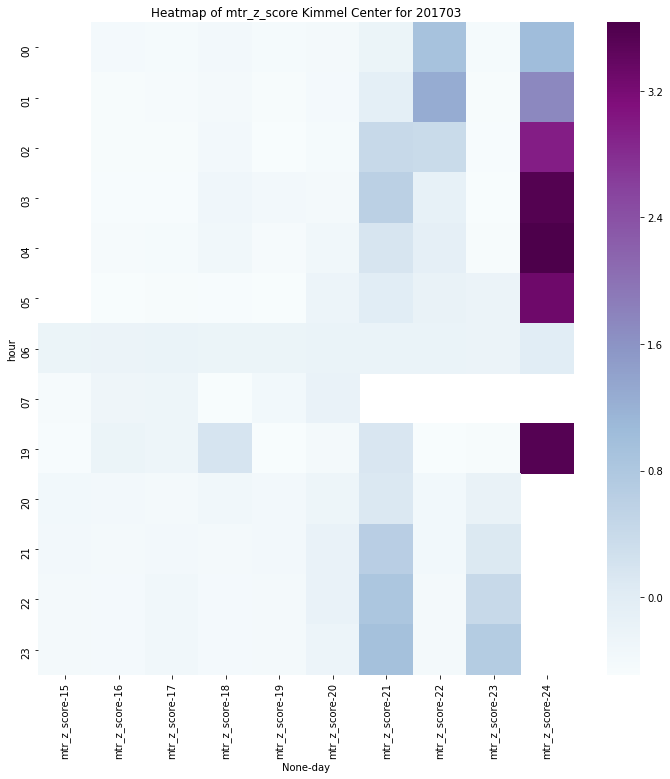

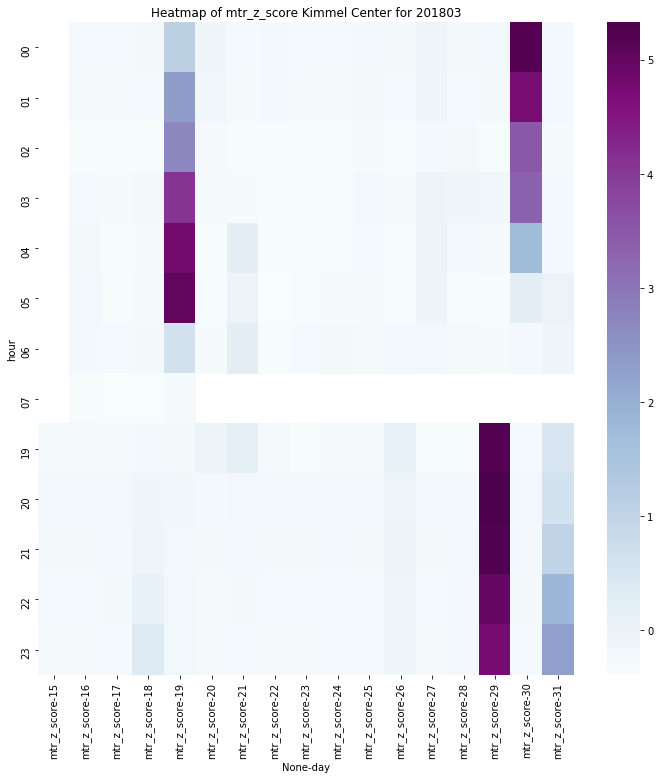

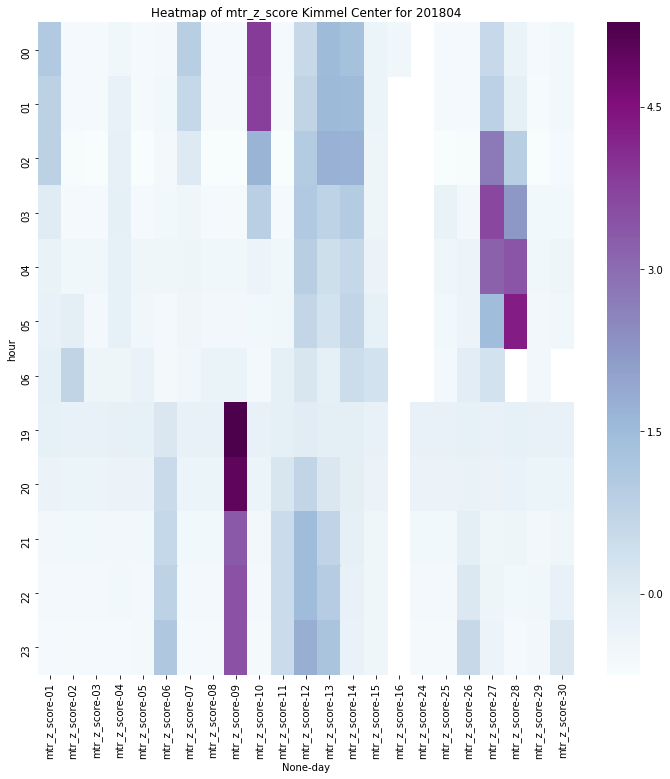

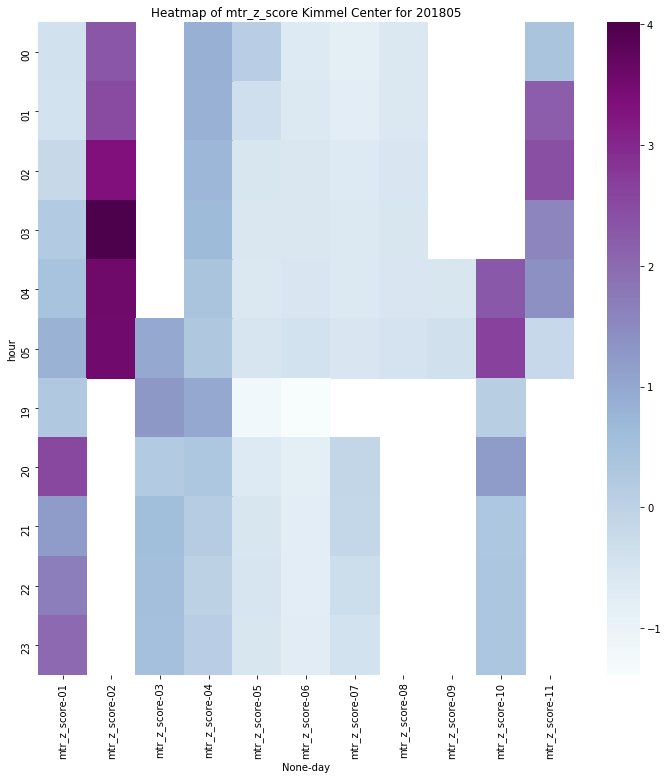

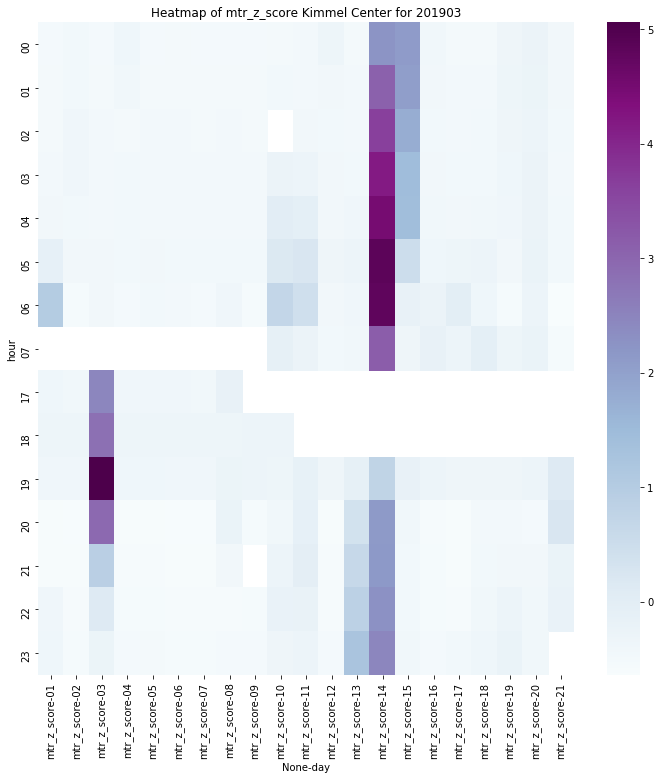

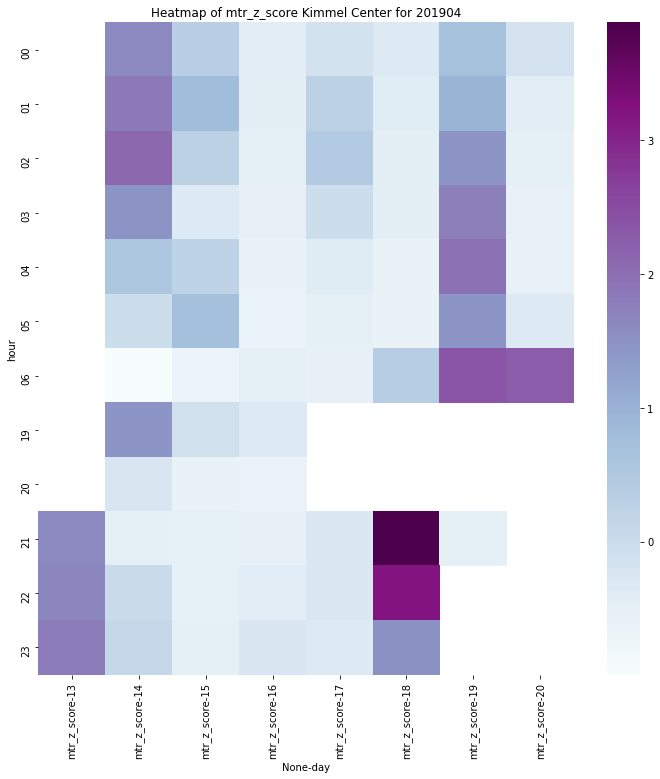

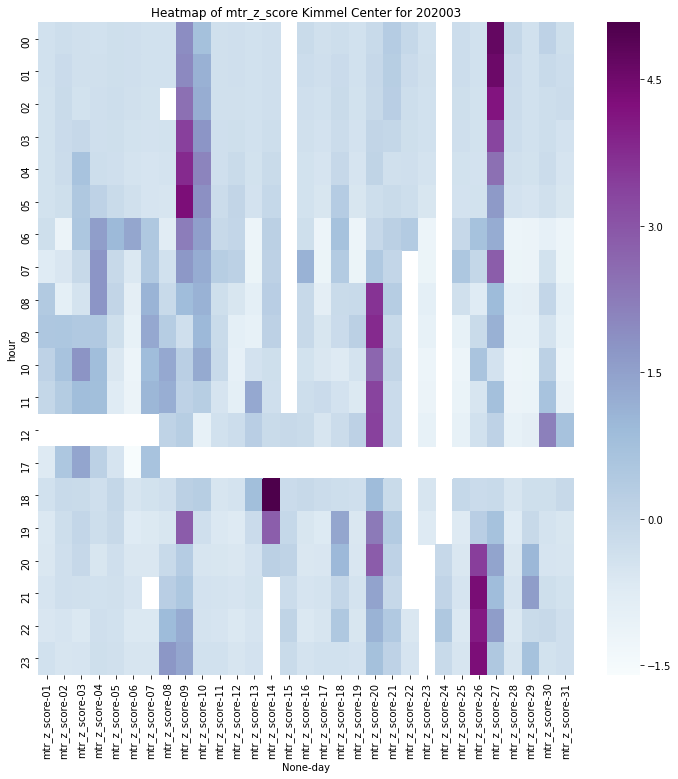

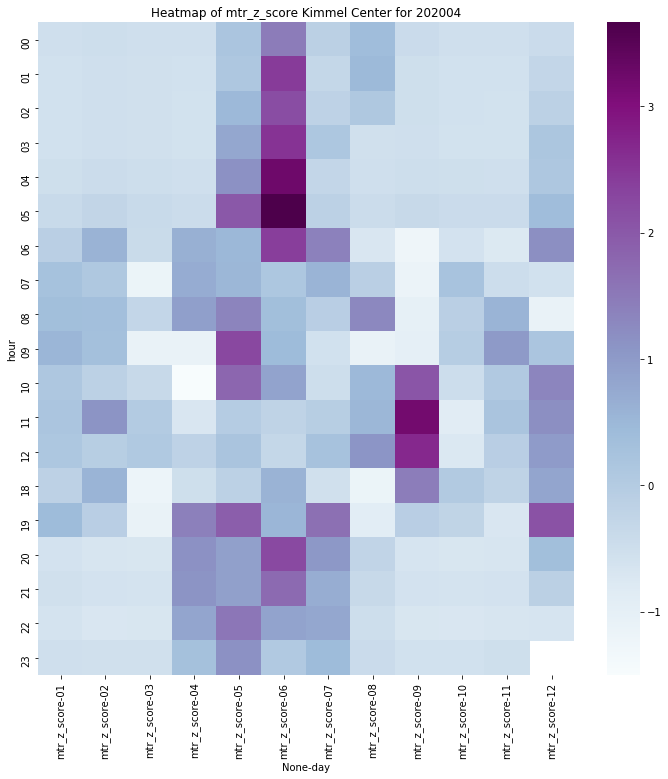

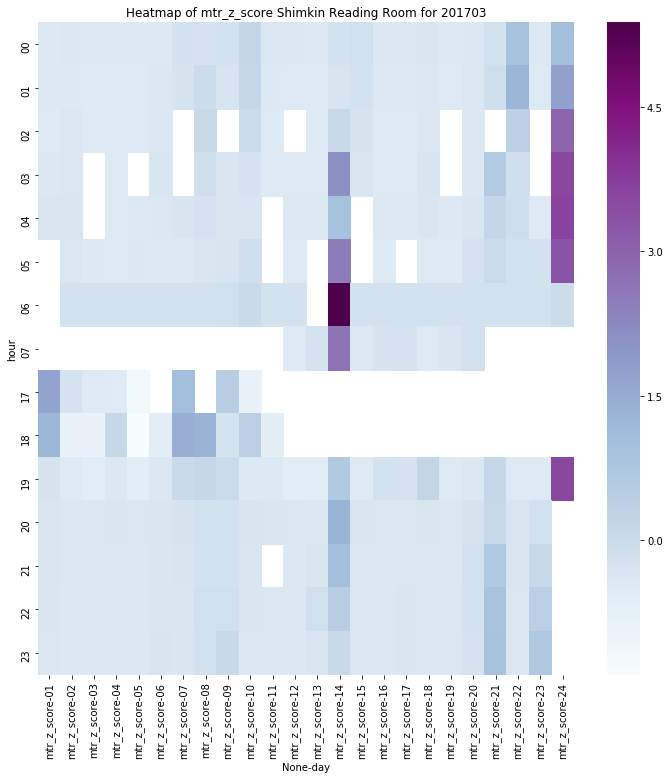

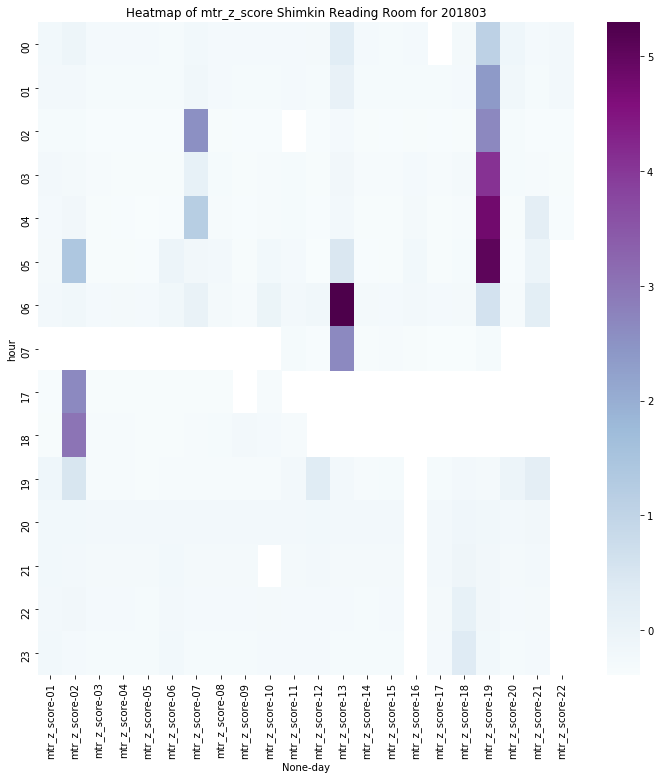

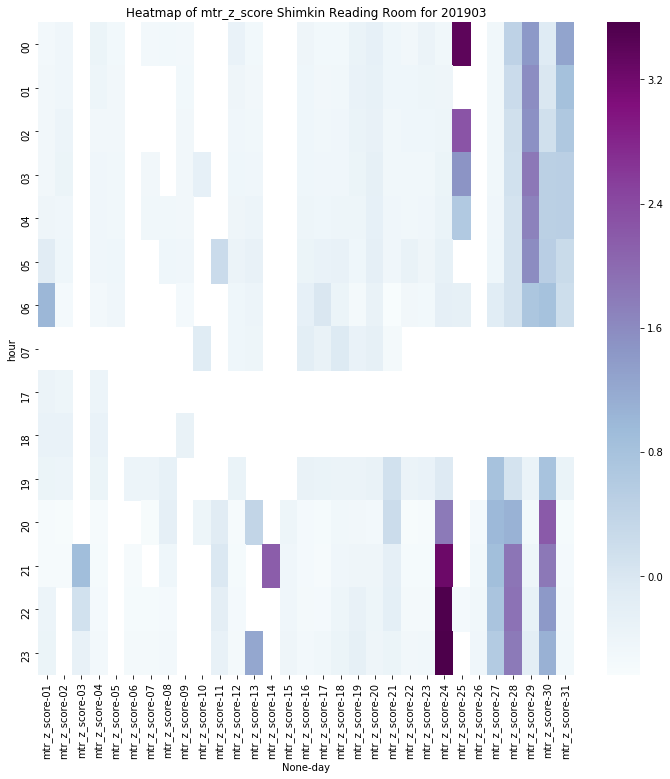

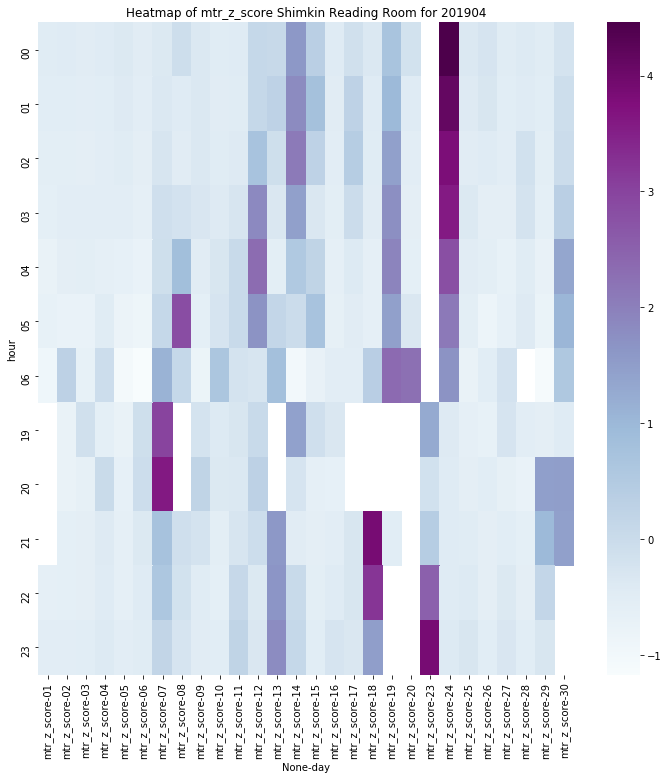

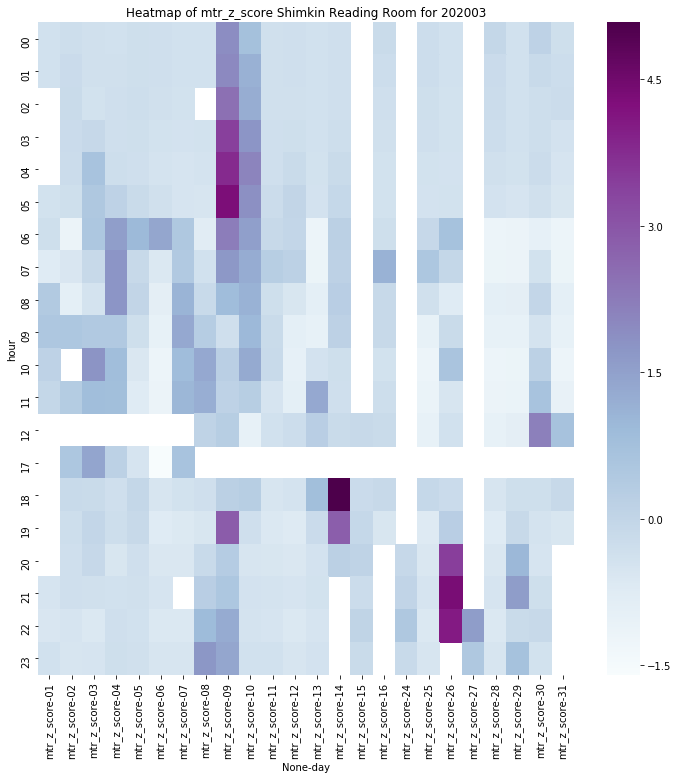

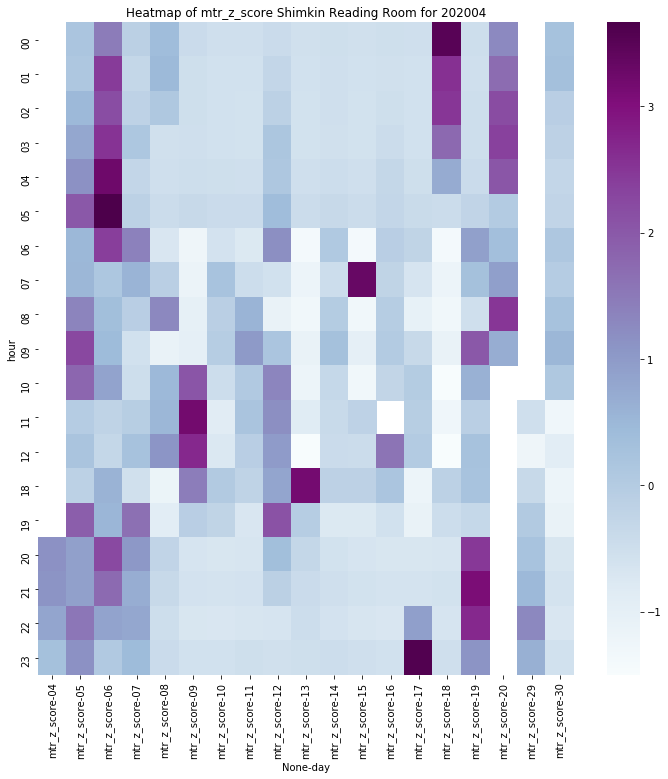

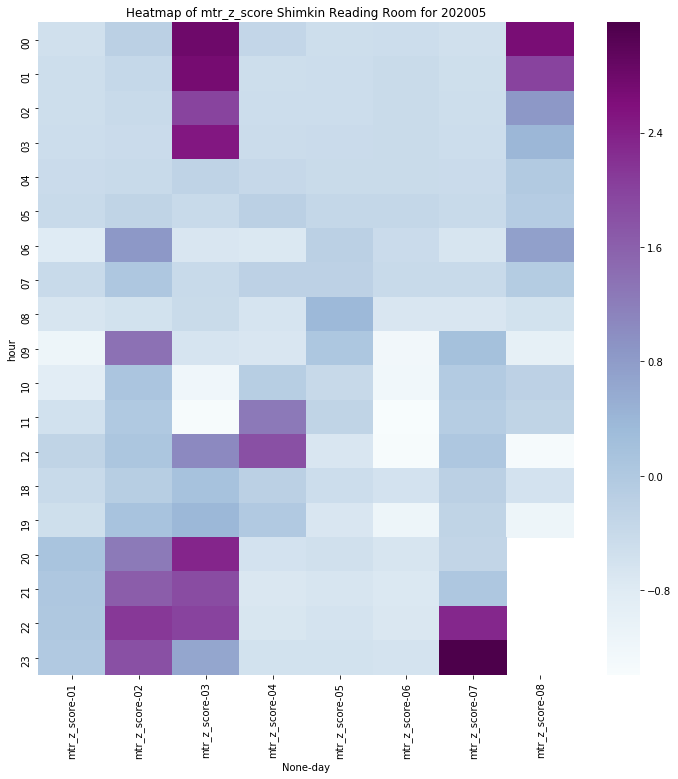

In [42]:
for sensor in nexradYamnetDict.keys():
    for yr_month in nexradYamnetDict[sensor].keys():
        fig = plt.figure(figsize=(12,12))
        r = sns.heatmap(nexradYamnetDict[sensor][yr_month][['day', 'hour', 'mtr_z_score']].pivot('hour', 'day'),
                cmap='BuPu')
        r.set_title('Heatmap of mtr_z_score '+sensor+' for '+''.join(yr_month))

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


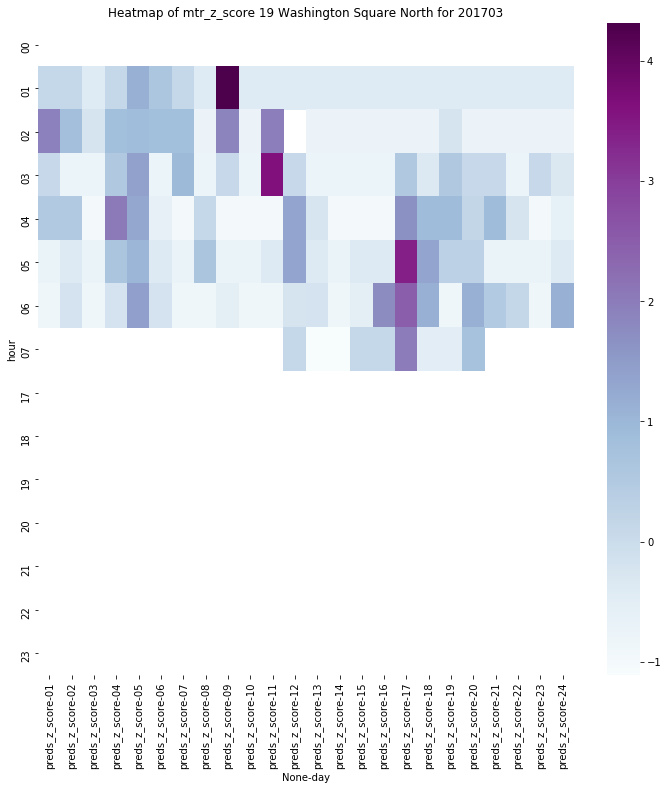

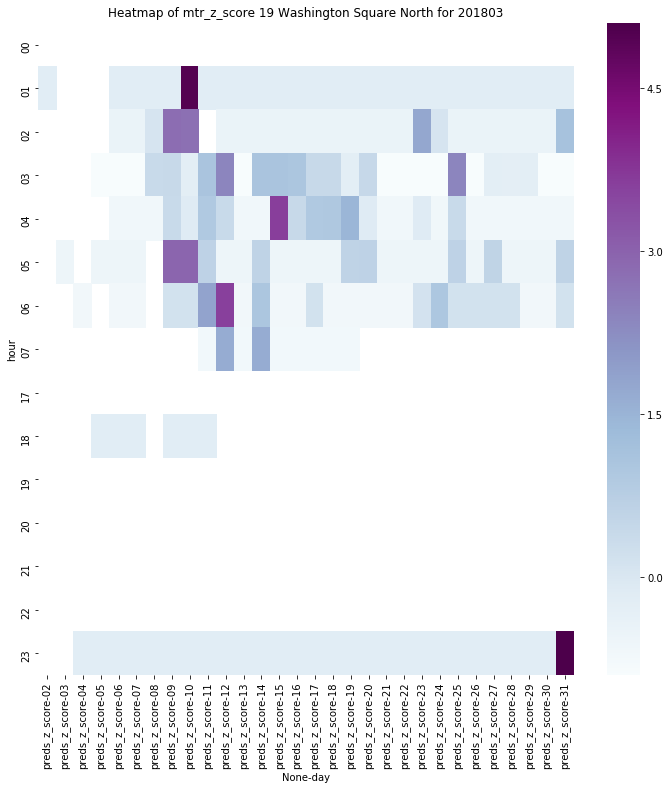

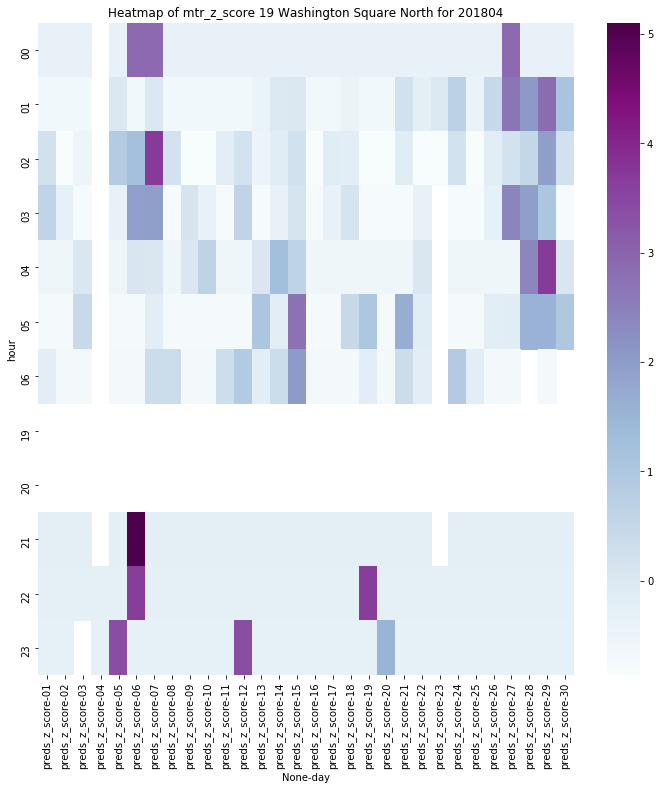

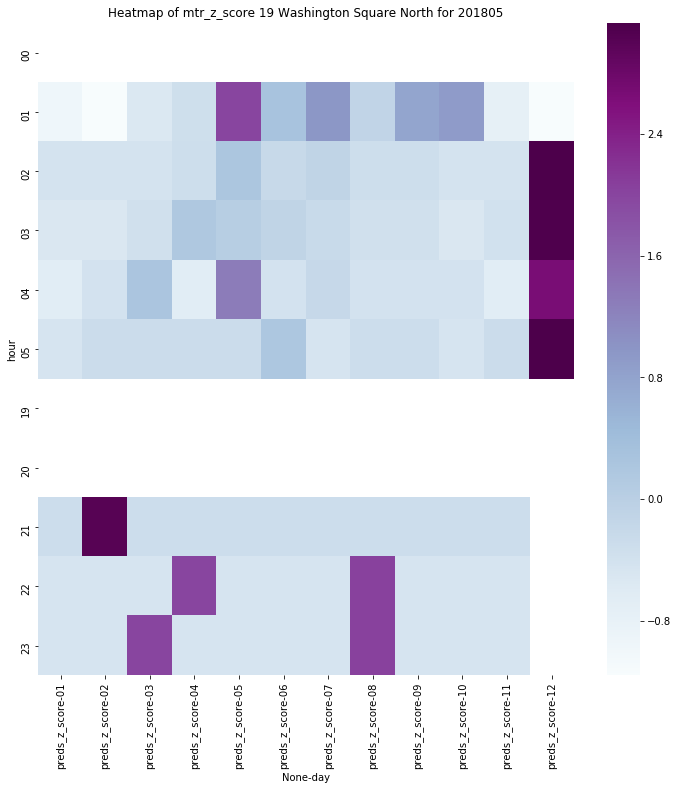

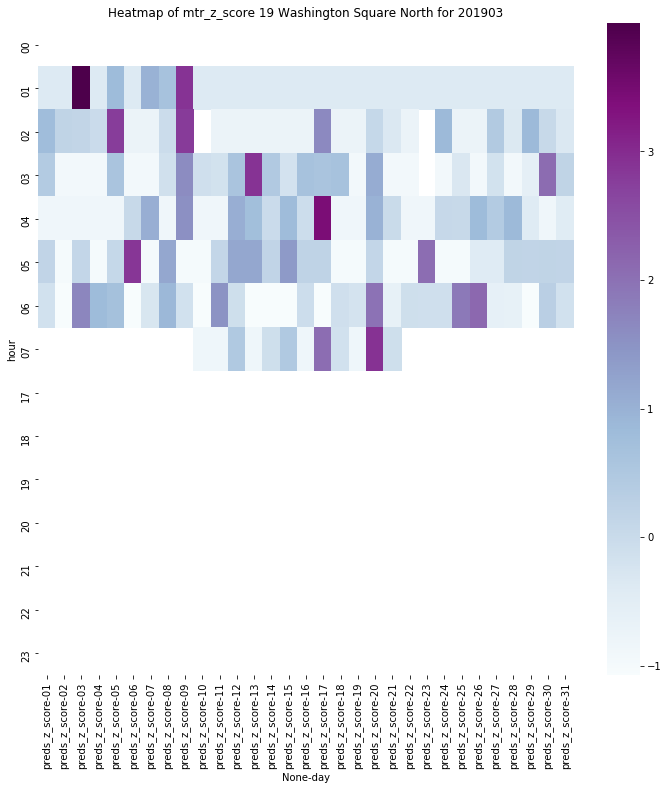

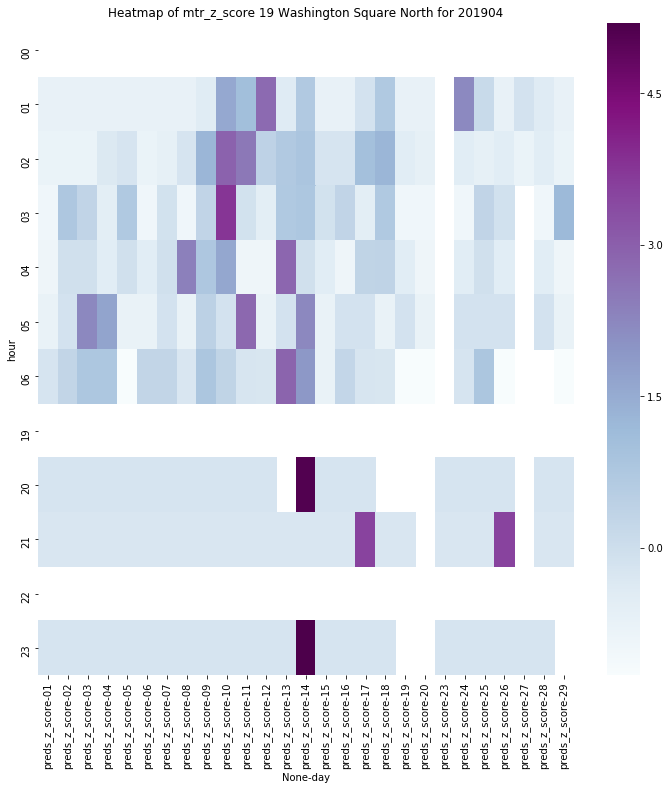

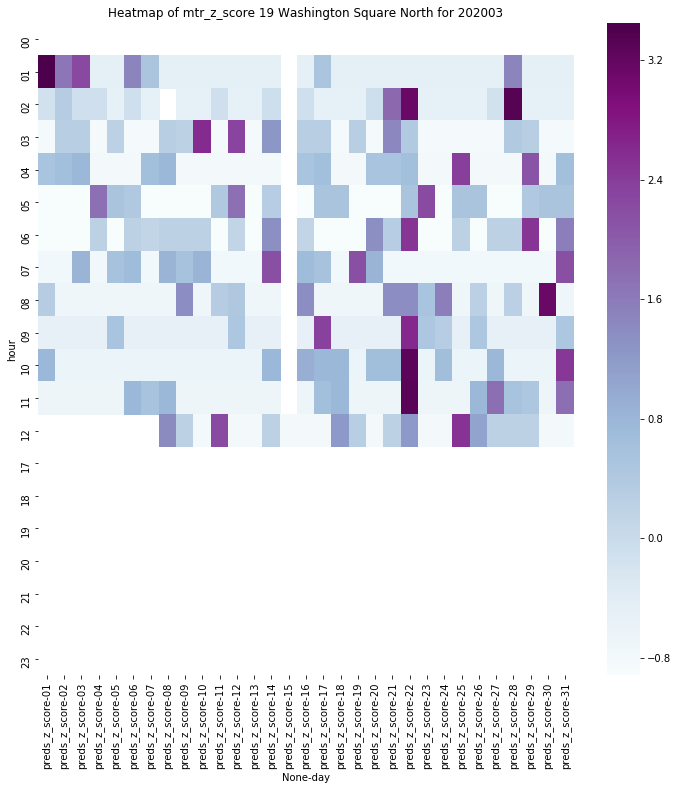

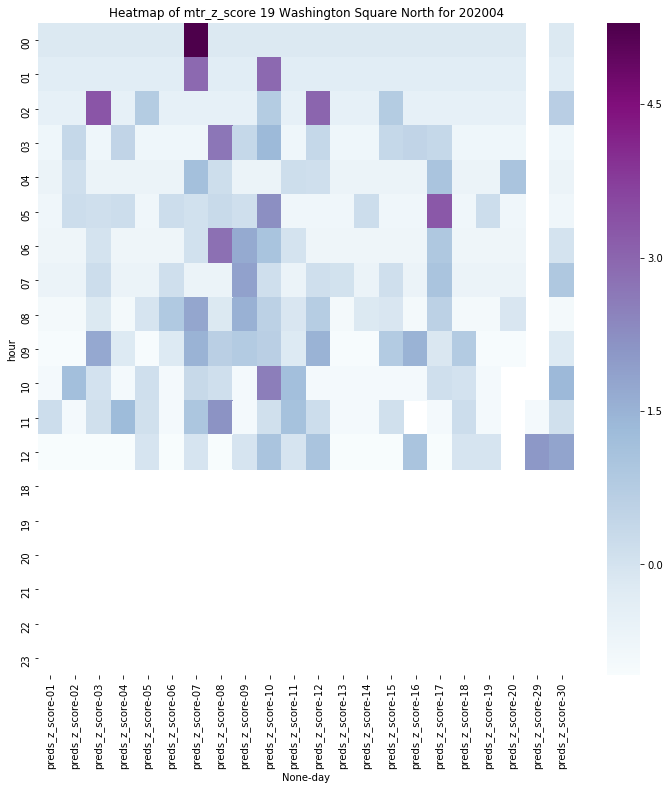

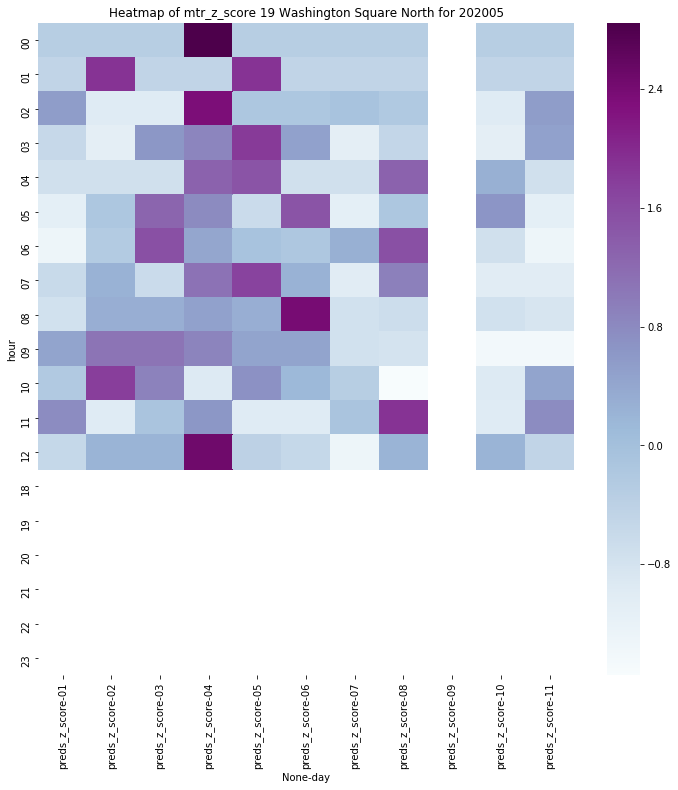

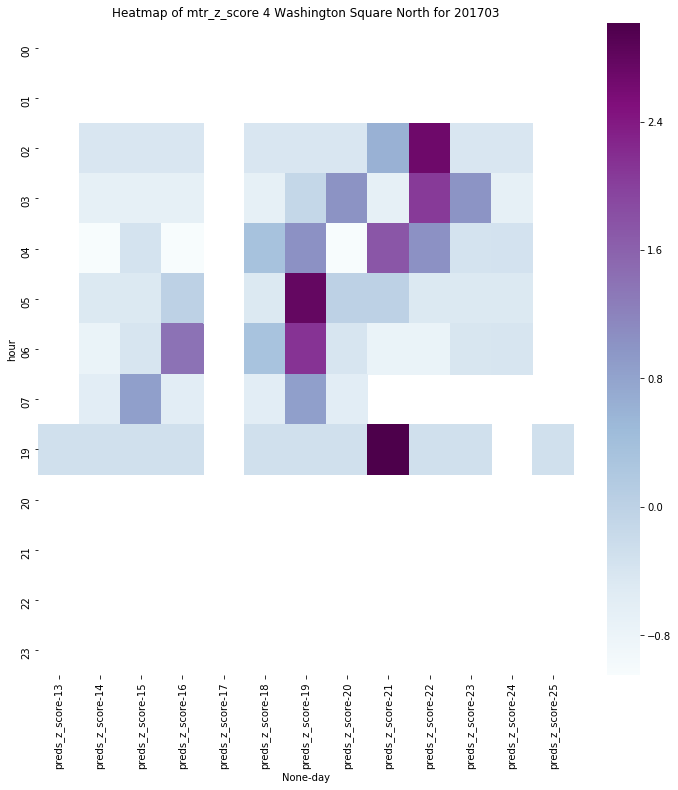

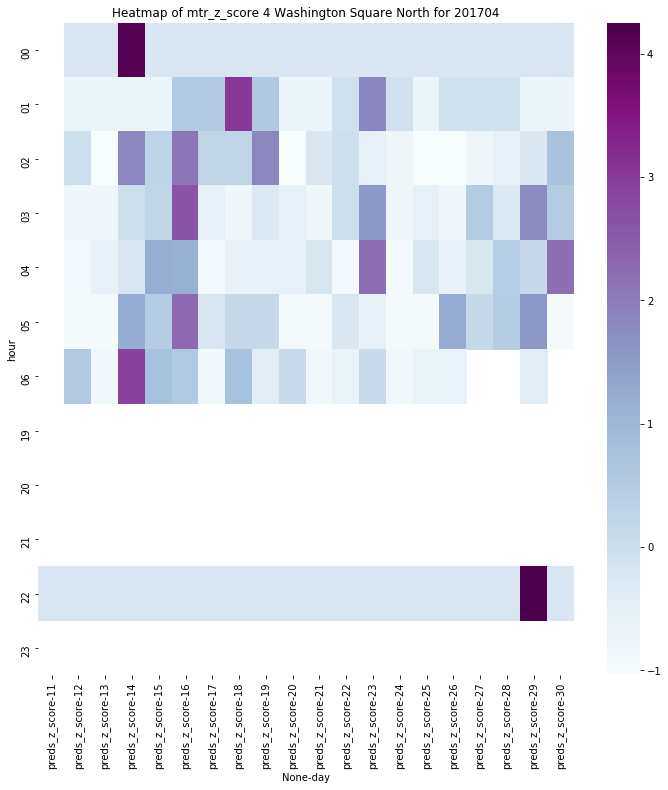

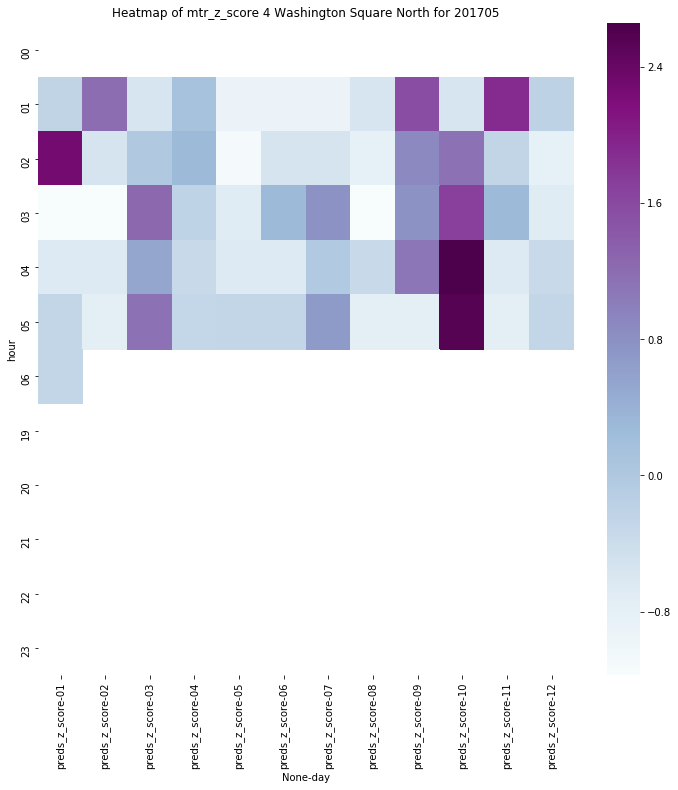

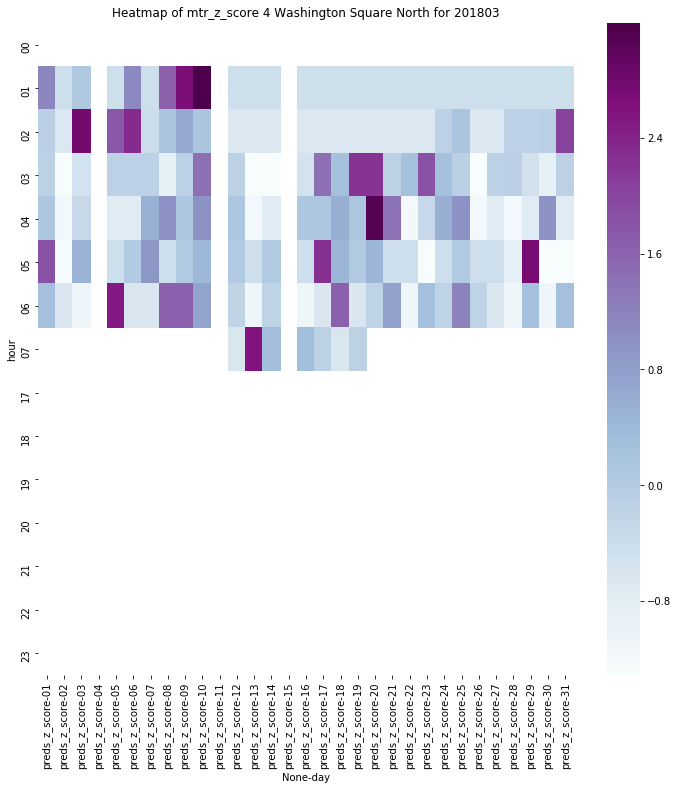

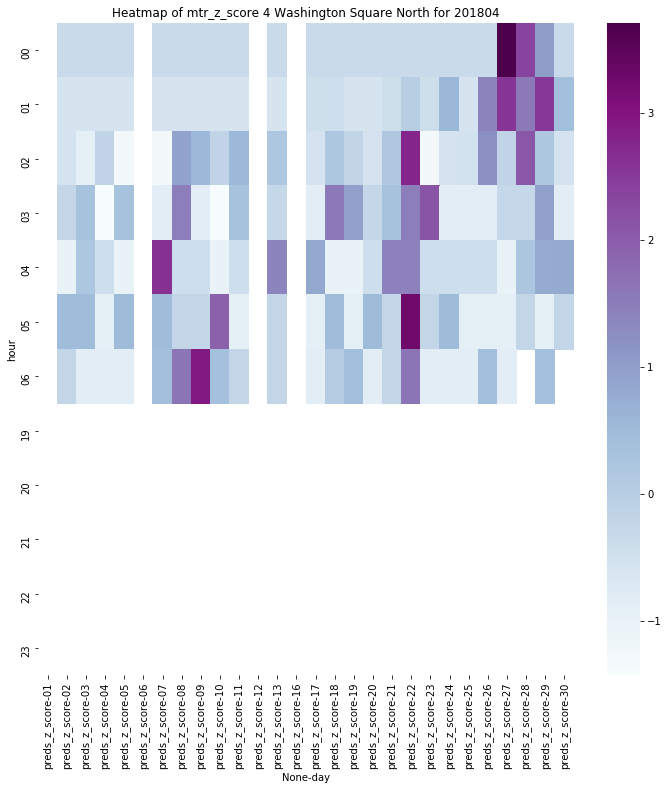

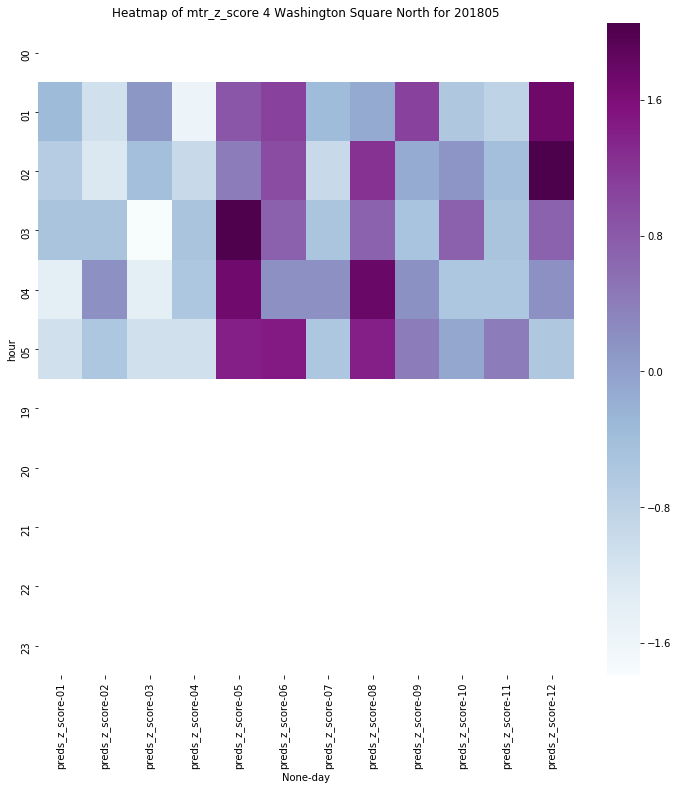

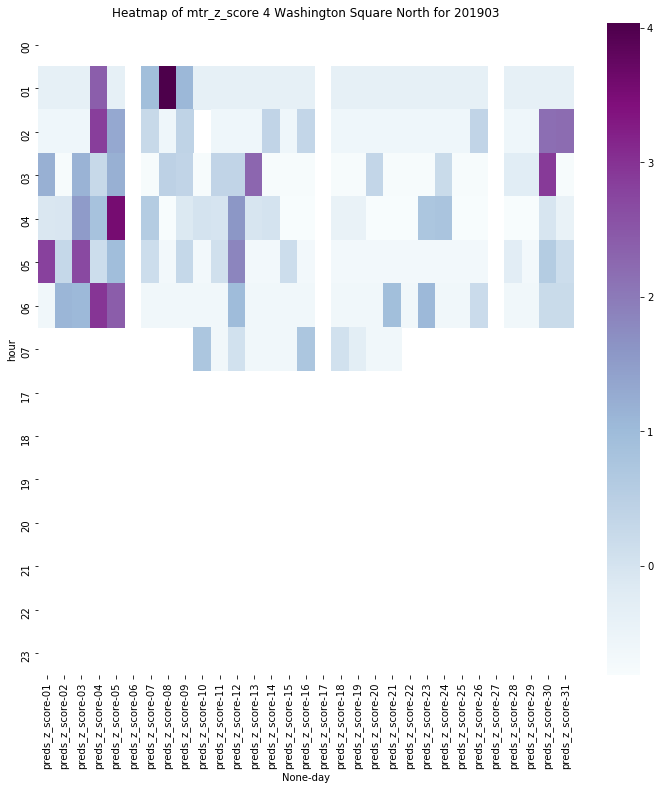

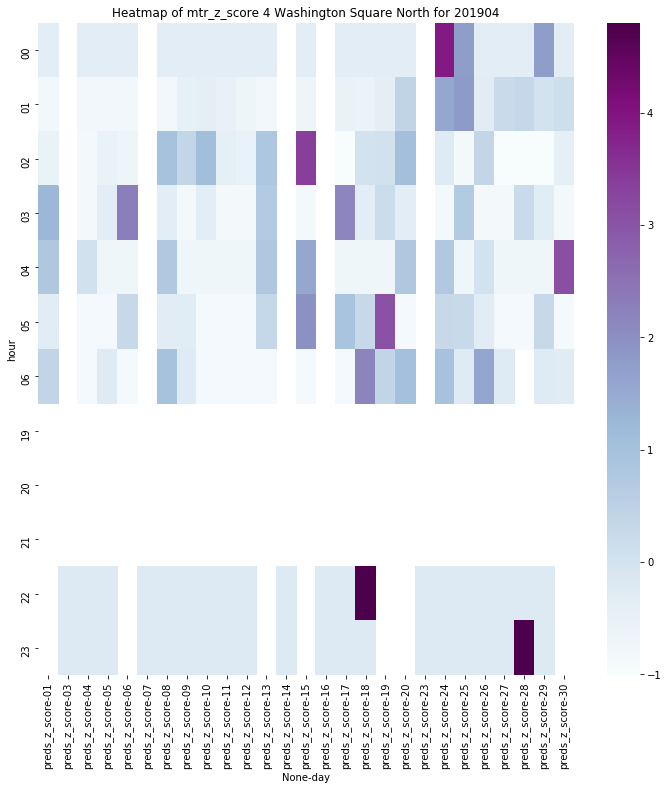

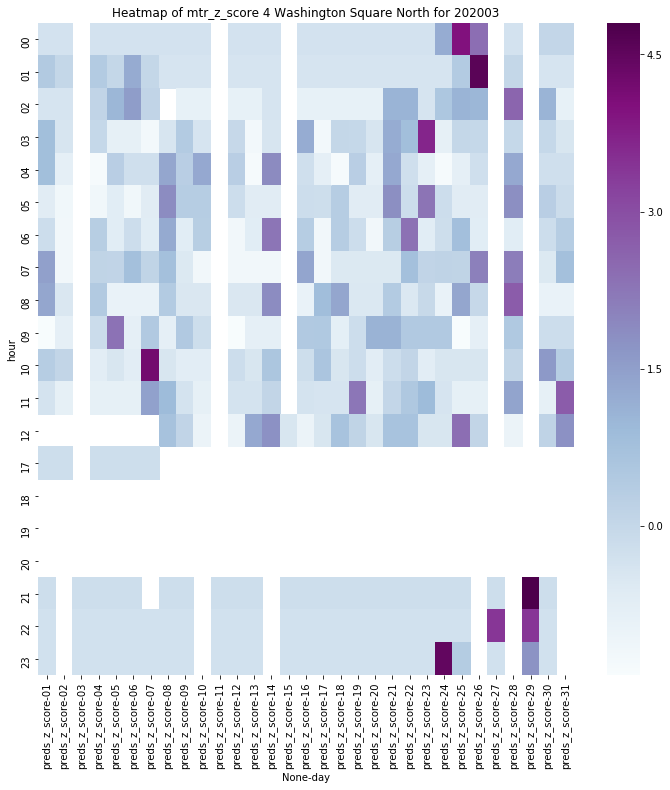

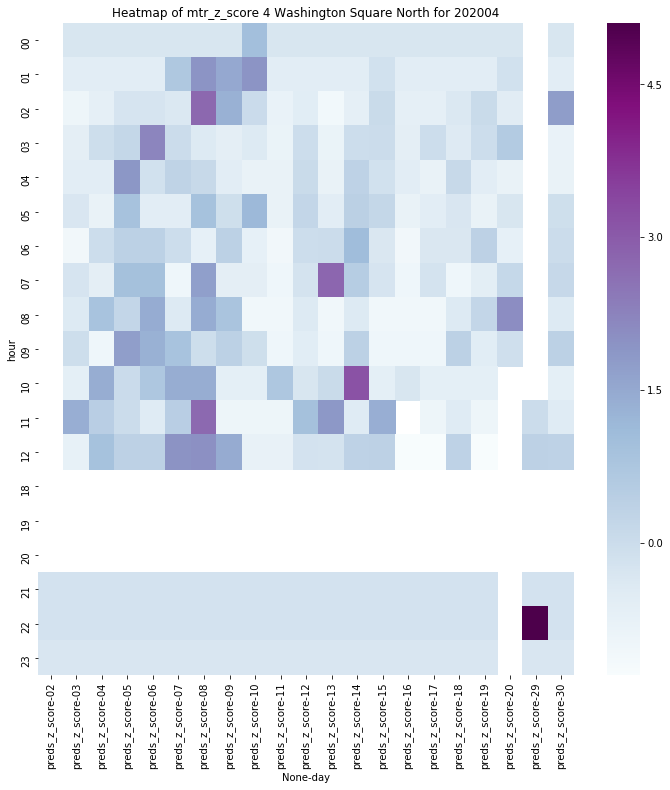

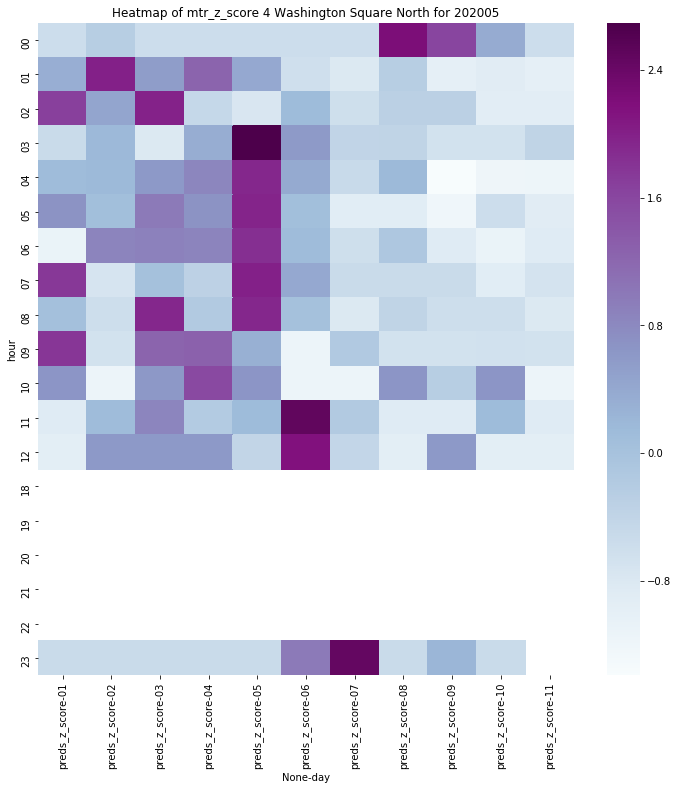

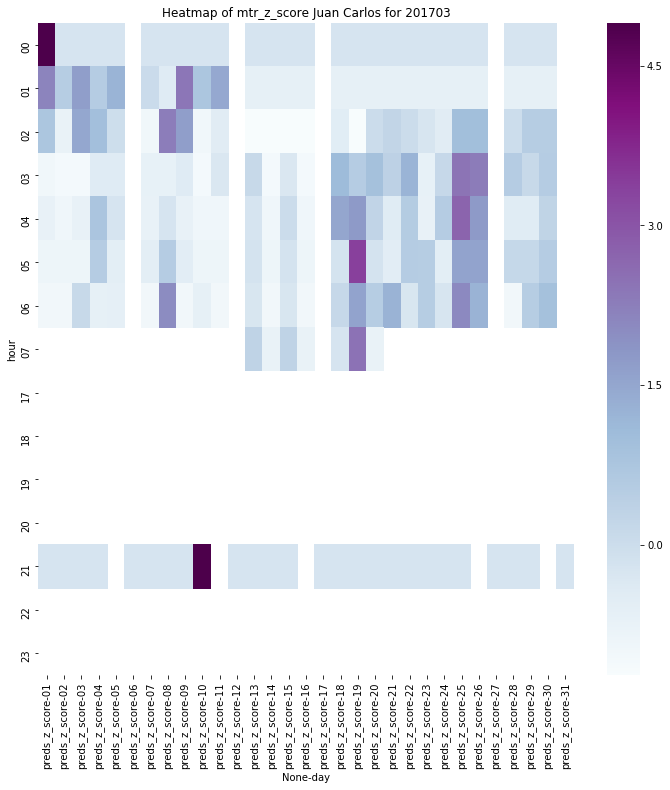

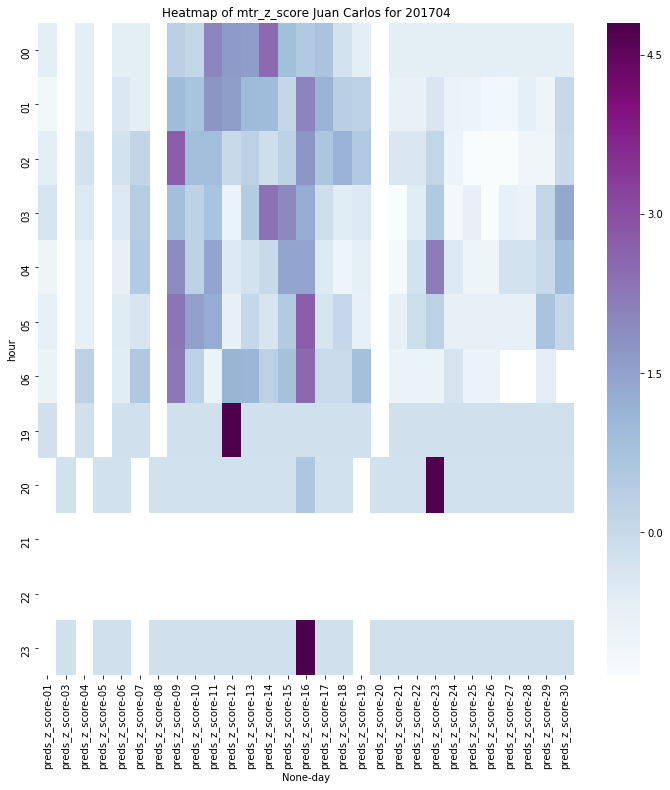

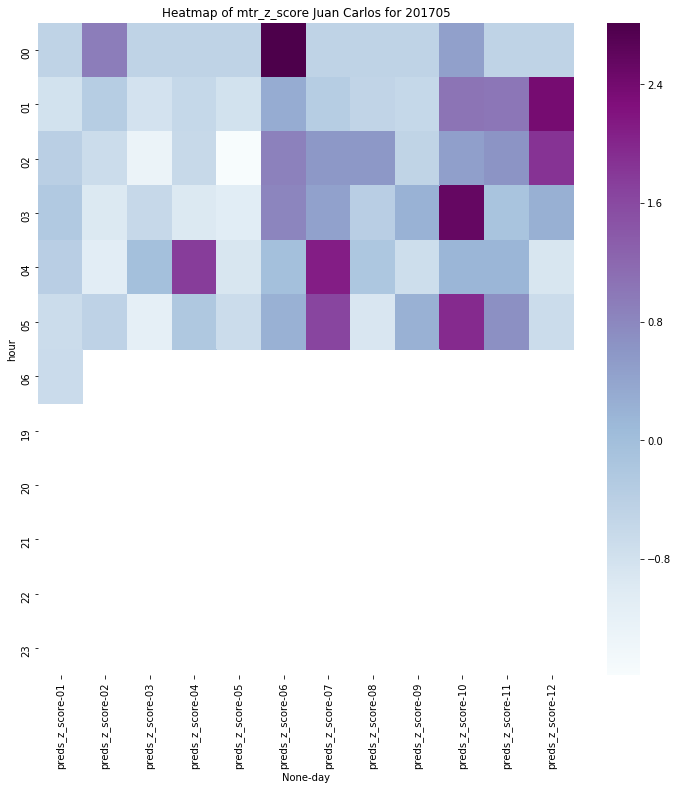

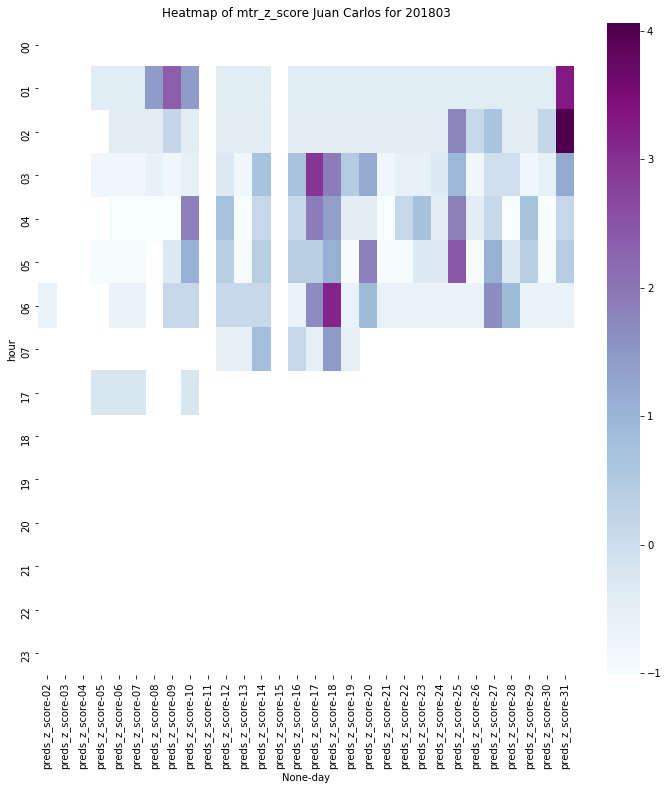

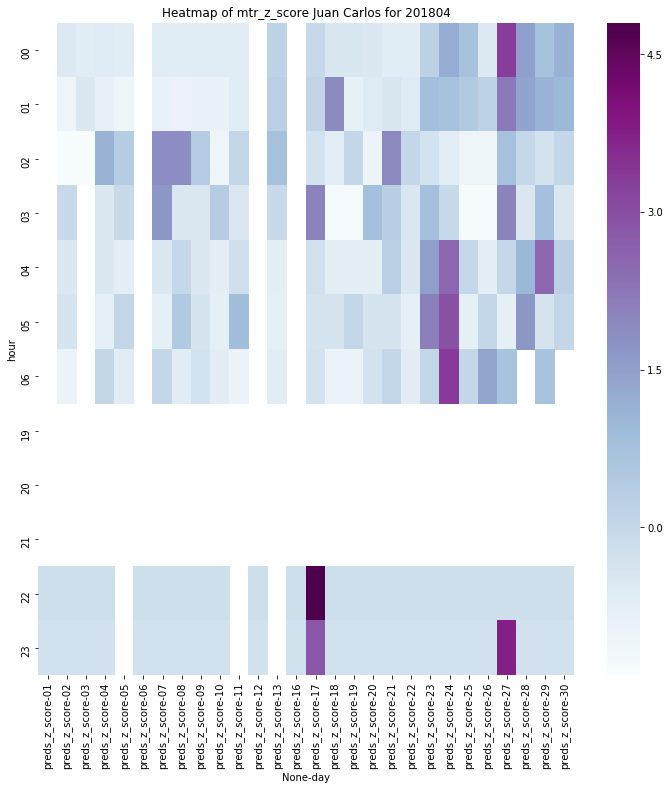

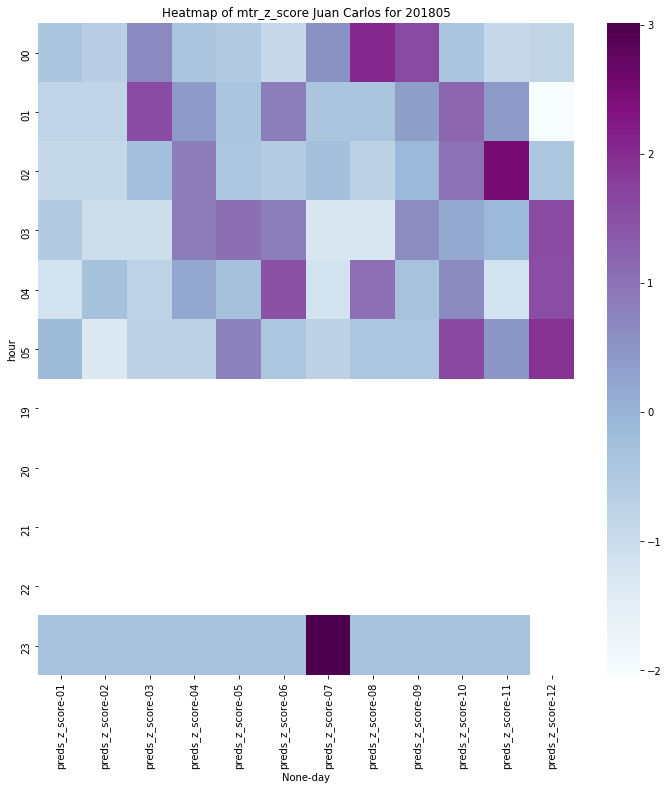

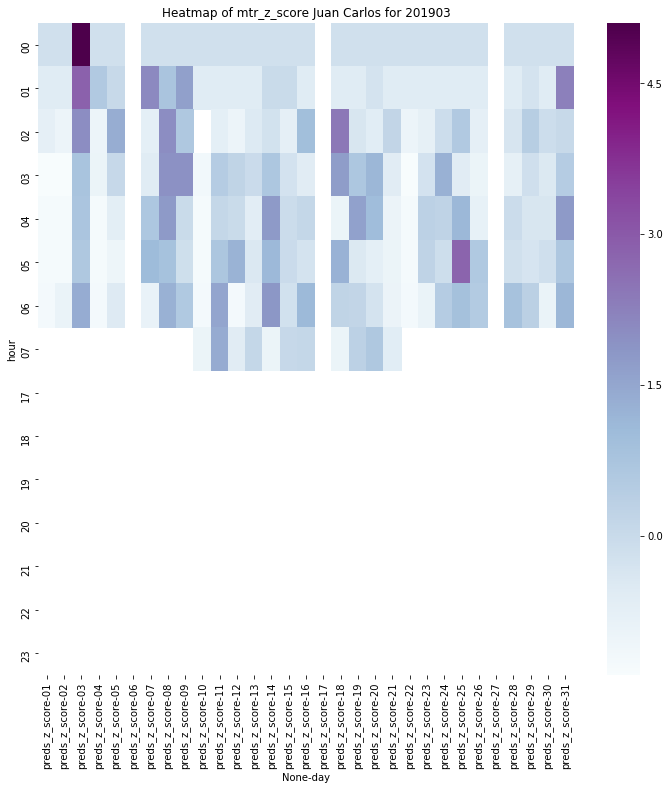

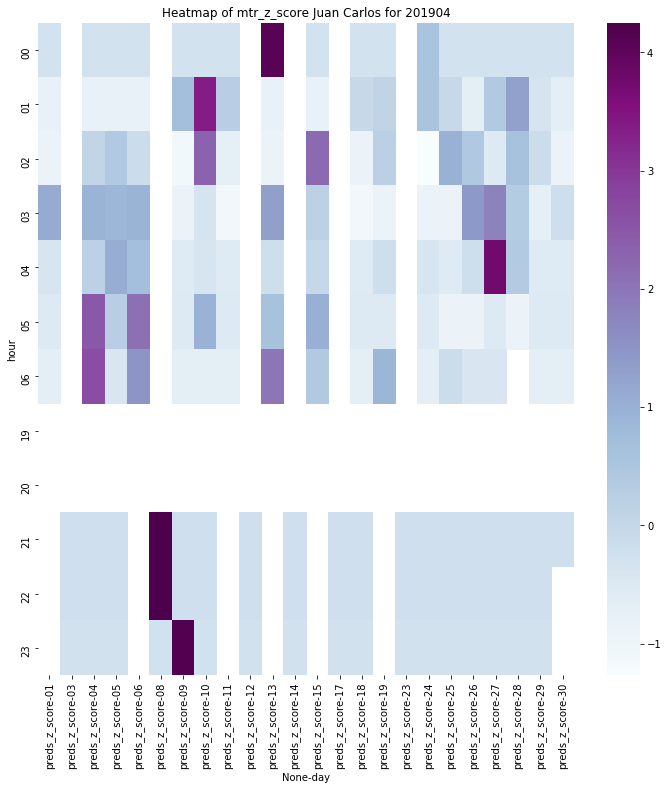

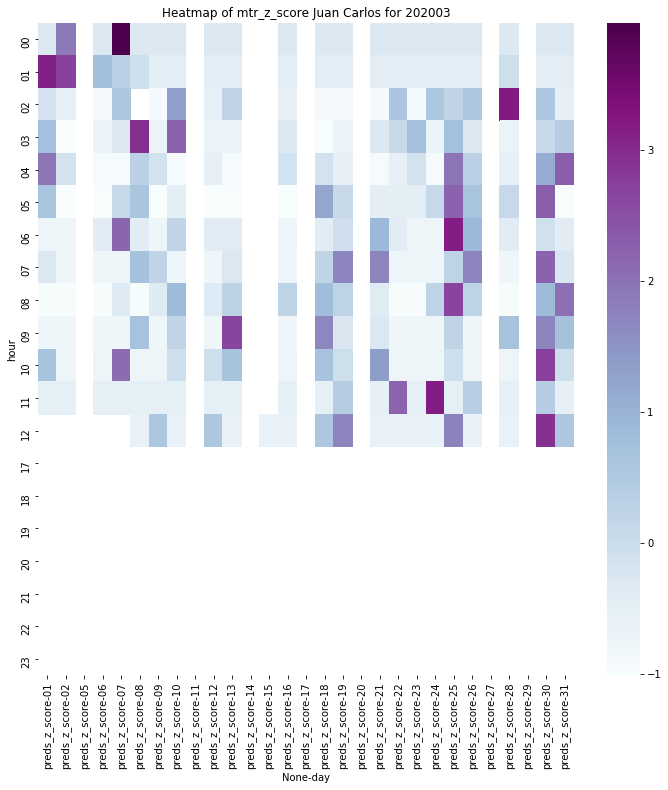

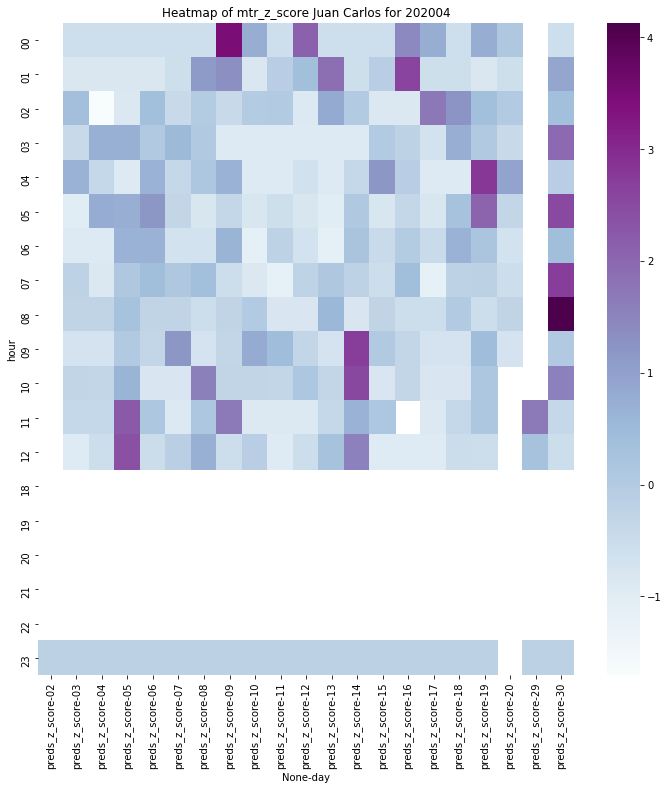

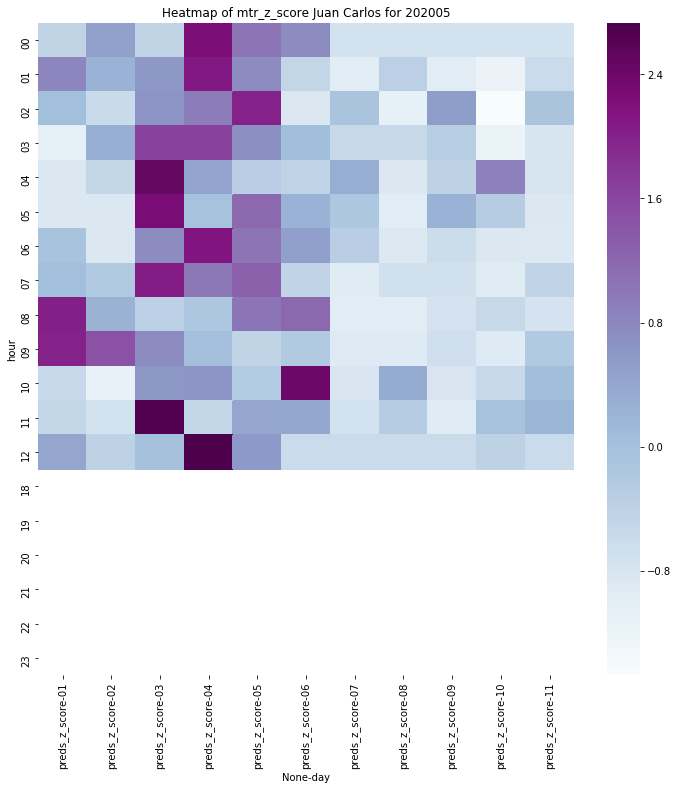

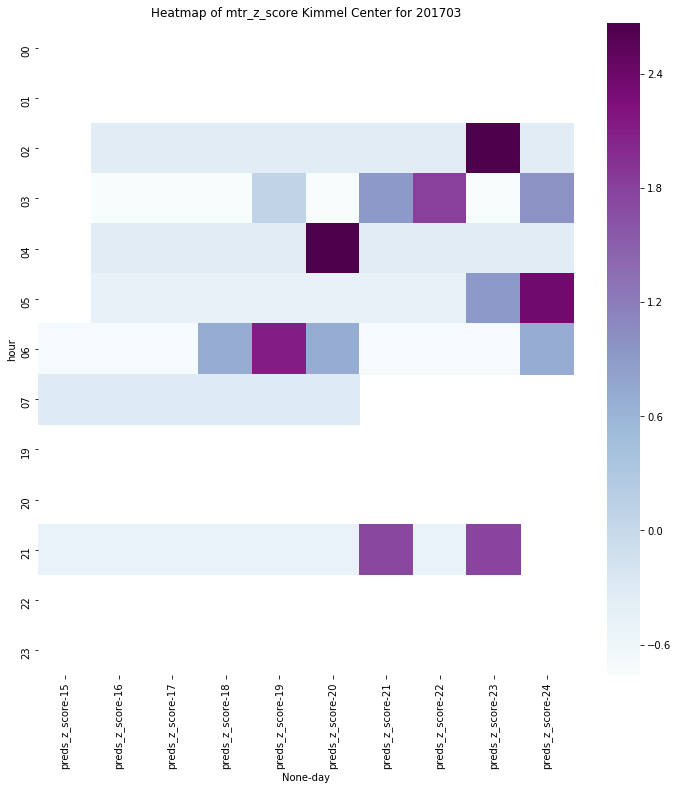

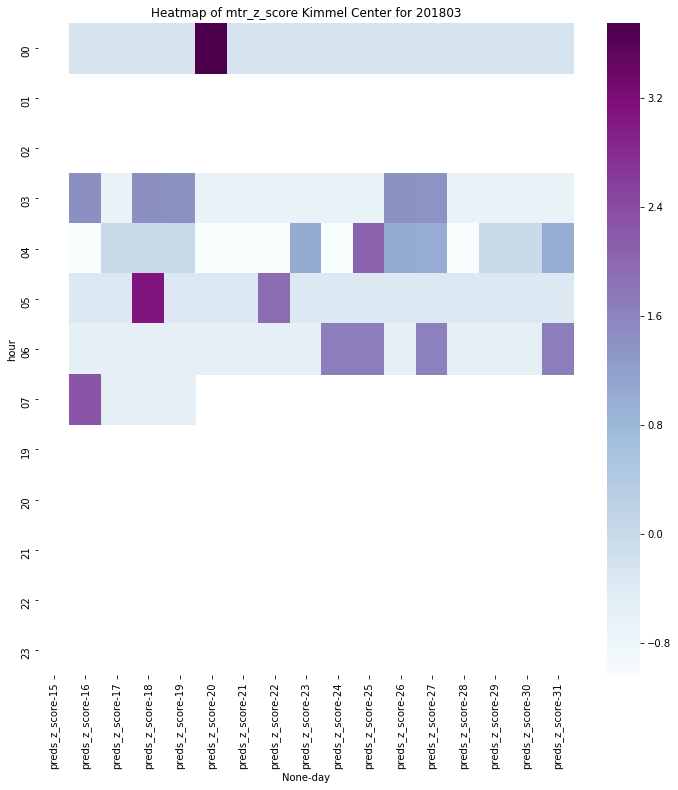

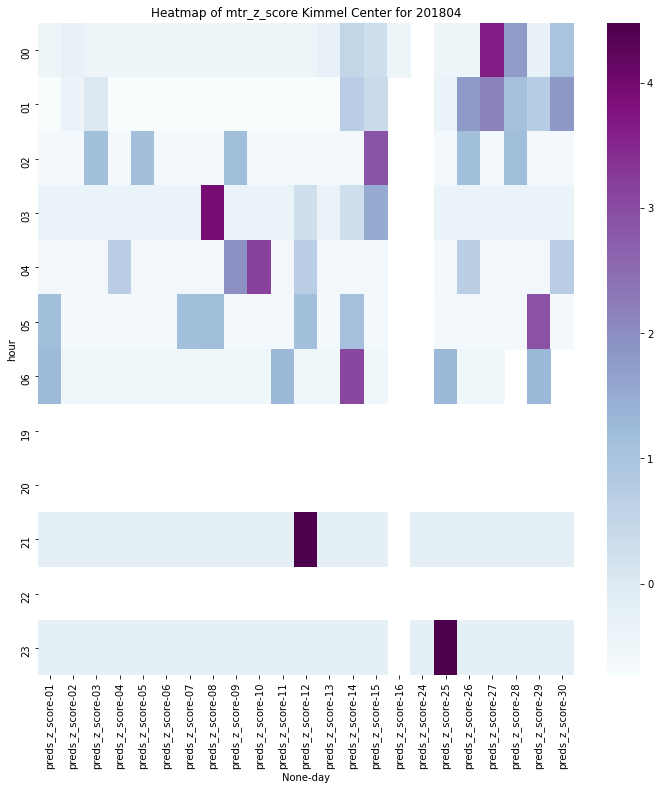

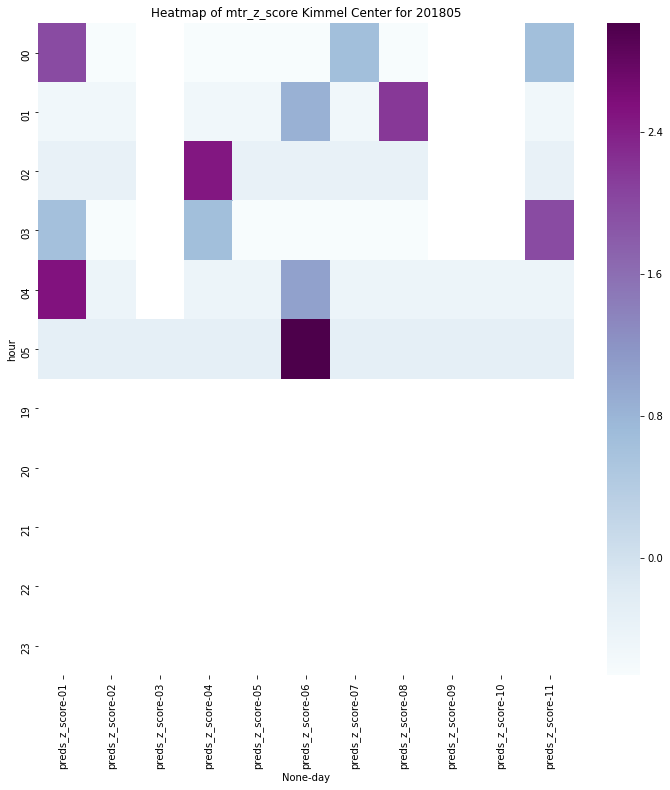

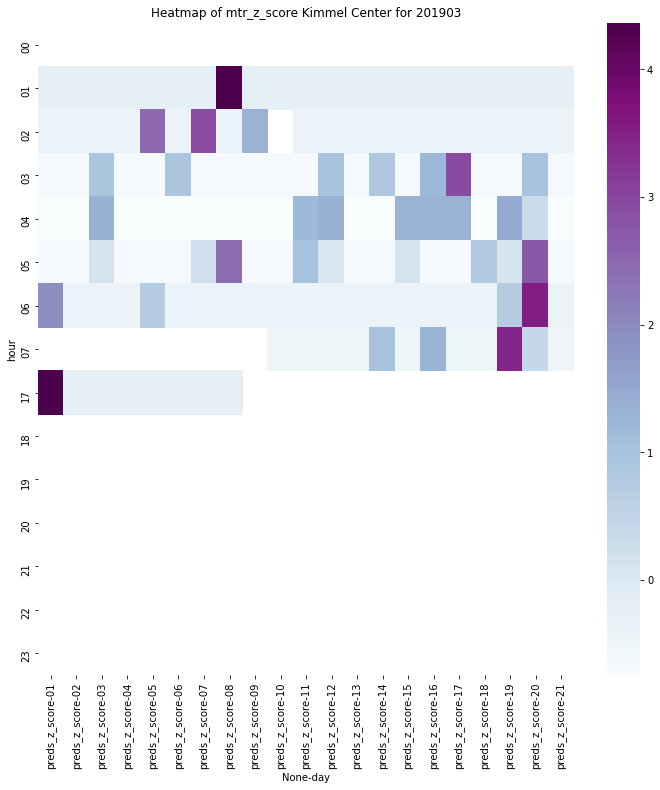

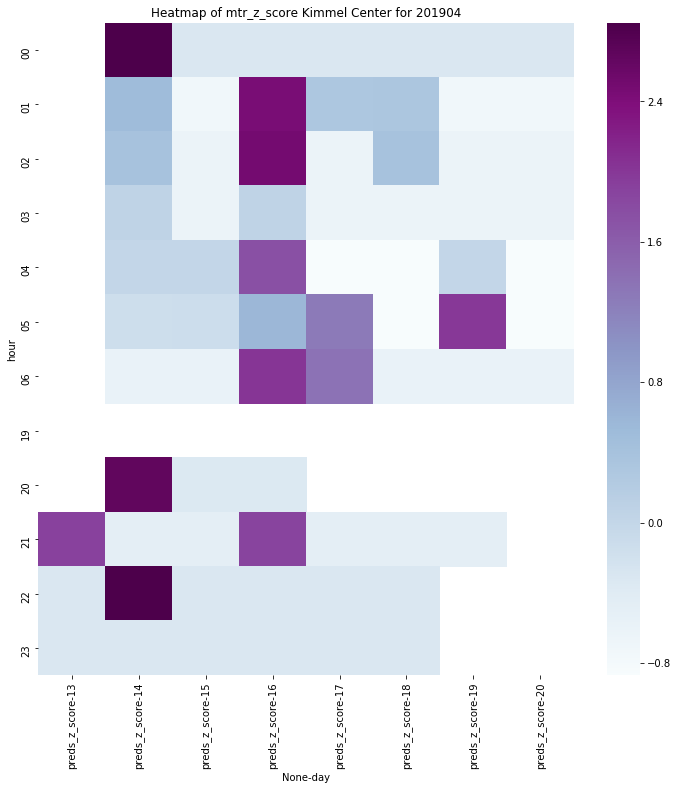

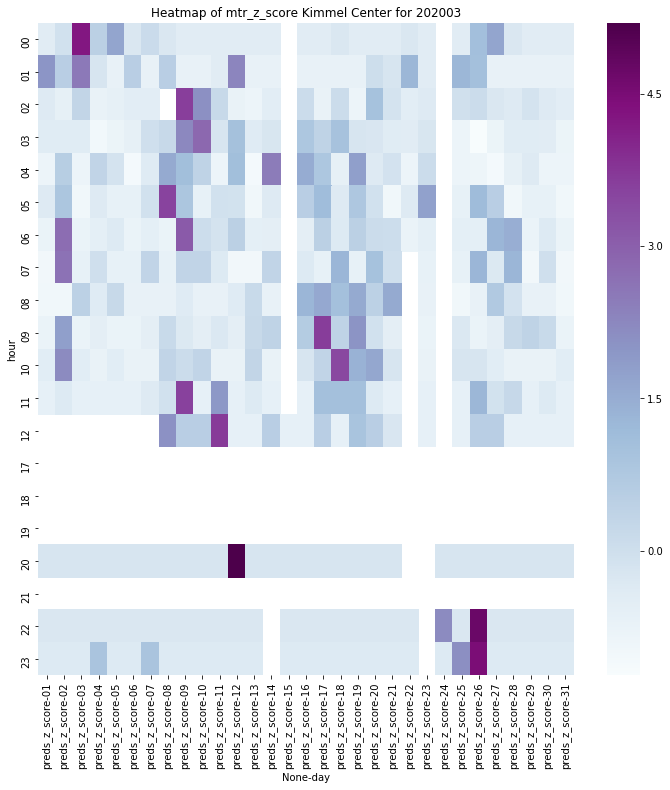

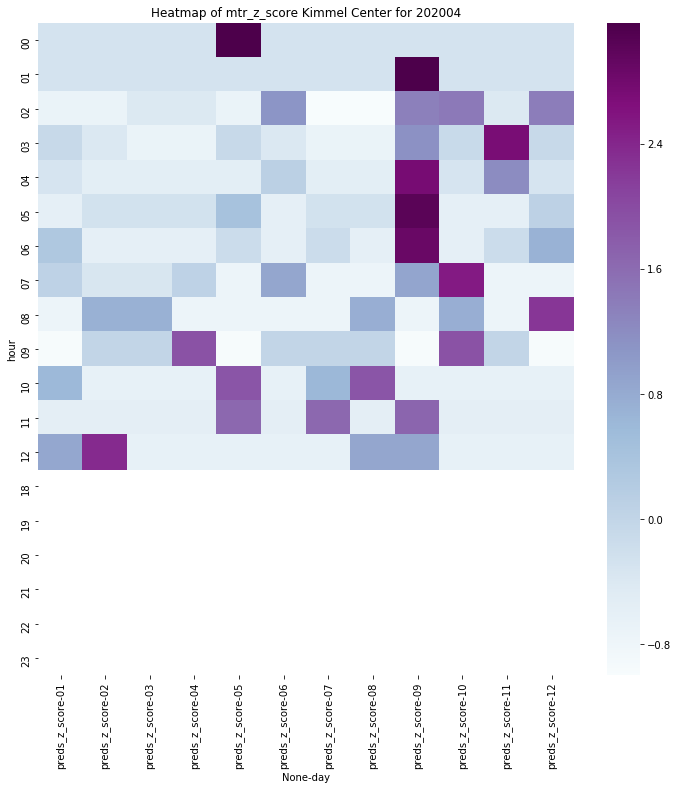

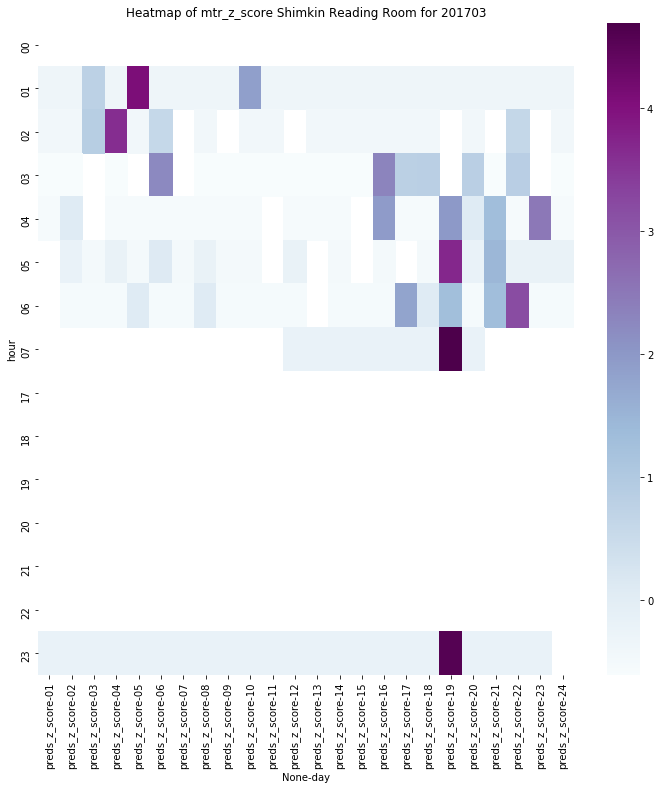

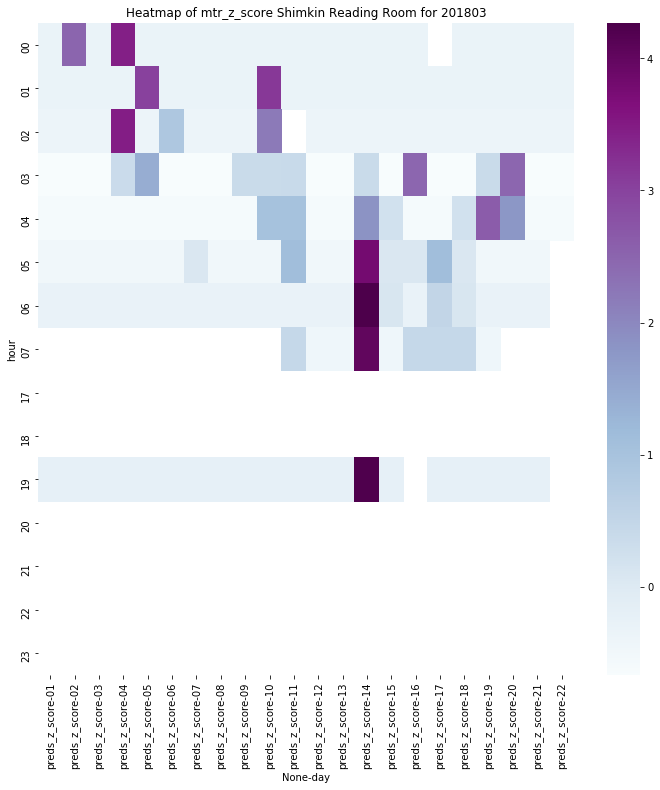

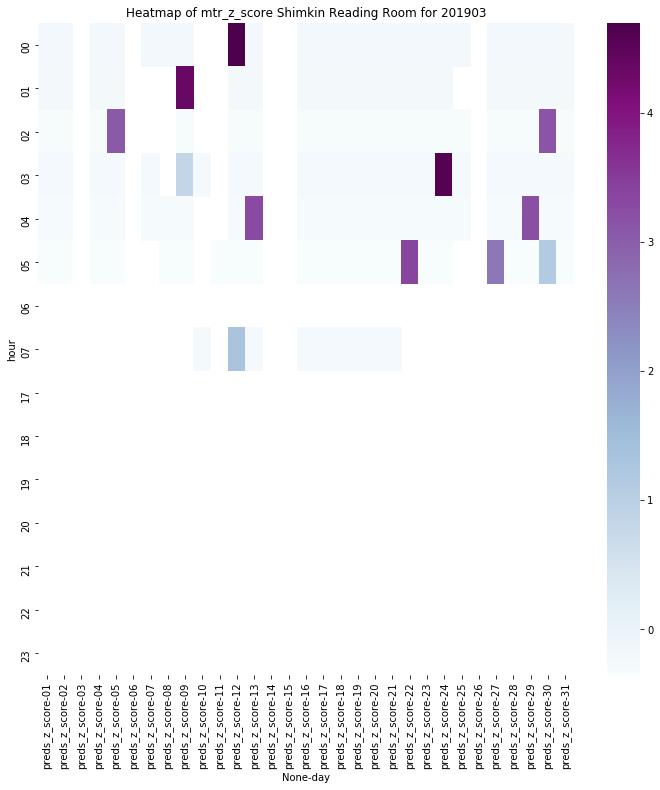

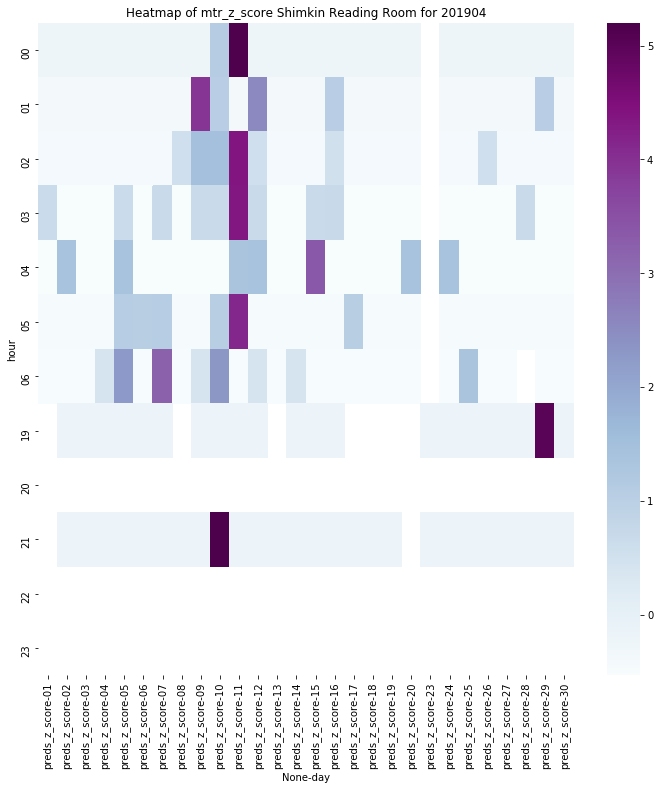

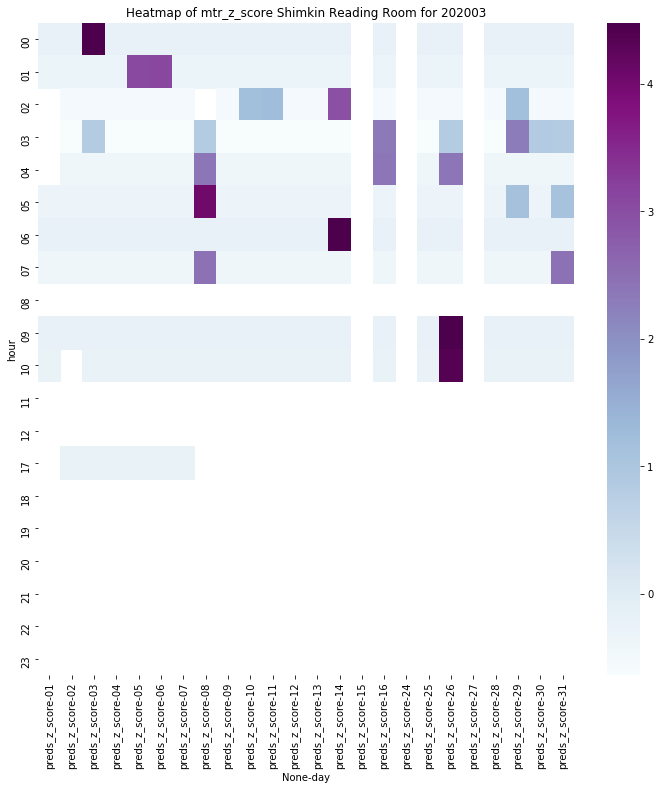

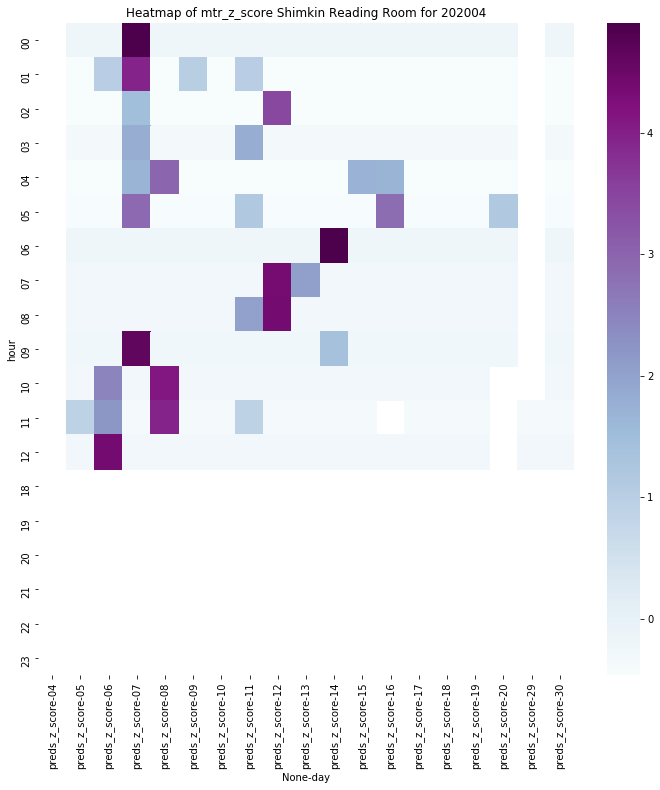

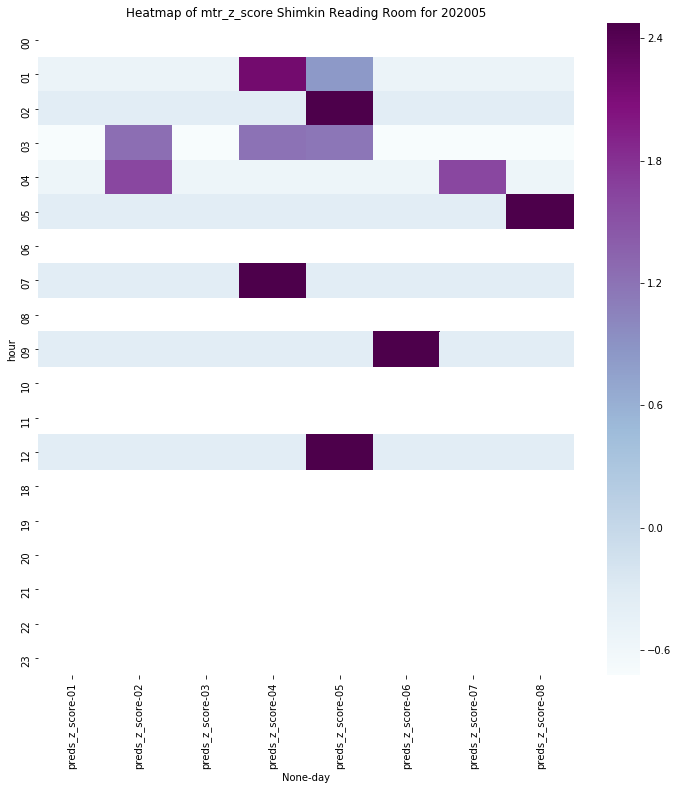

In [43]:
for sensor in nexradYamnetDict.keys():
    for yr_month in nexradYamnetDict[sensor].keys():
        fig = plt.figure(figsize=(12,12))
        r = sns.heatmap(nexradYamnetDict[sensor][yr_month][['day', 'hour', 'preds_z_score']].pivot('hour', 'day'),
                cmap='BuPu')
        r.set_title('Heatmap of preds_z_score '+sensor+' for '+''.join(yr_month))